#  AYUDANTÍA NO PRESENCIAL

## 1) MODELOS COMBINADOS

### Cargar librerias

In [36]:
#install.packages("MASS")
#install.packages("randomForest")
#install.packages("ggplot2")
#install.packages("tibble")
#install.packages("dplyr")
#install.packages("ipred")
set.seed(125)
library(MASS)
library(randomForest)
library(ggplot2)
library(tibble)
library(dplyr)
library(ipred)

### Cargar set de datos
Separamos en train y test.

**NOTA:**Dado que las etapas de preprocesamiento y transformacion no son el foco seran omitidas


In [37]:
data("Boston")
index <- sample(nrow(Boston),nrow(Boston)*0.70) # separar train/test
boston.train <- Boston[index,]
boston.test <- Boston[-index,]
rm(Boston)

### Exploración del set

El data set tiene 14 columnas: 1 variables respuesta y 13 predictores.

In [38]:
head(Boston)

crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.00632,18,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
0.02731,0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
0.02729,0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
0.03237,0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
0.06905,0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
0.02985,0,2.18,0,0.458,6.430,58.7,6.0622,3,222,18.7,394.12,5.21,28.7


## Bagging

En lugar de ajustar un único árbol, se ajustan muchos de ellos en paralelo formando un “bosque”. En cada nueva
predicción, todos los árboles que forman el “bosque” participan aportando su predicción. Como valor final, se toma la
media de todas las predicciones (variables continuas) o la clase más frecuente (variables cualitativas). Uno de los
métodos de bagging más conocidos es Random Forest. El paquete de R "ipred", tiene funciones facilitadoras para el
Bagging.

**Instalamos el paquete ipred**

In [39]:
#install.packages("ipred")
library(ipred)

## Bagging para un arbol de decisiones
**Modelo simple de Bagging con 100 replicaciones.** Calculamos el error cuadrático medio.

In [40]:
boston.bag<- bagging(medv~., data = boston.train, nbagg=100)
boston.bag.pred<- predict(boston.bag, newdata = boston.test)
mean((boston.test$medv-boston.bag.pred)^2)
rm(boston.bag,boston.bag.pred)

[1] 14.60084

**Para el caso de un árbol normal.**

In [43]:
#install.packages("rpart")
library(rpart)


In [45]:
boston.tree<- rpart(medv~., data = boston.train)
boston.tree.pred<- predict(boston.tree, newdata = boston.test)
mean((boston.test$medv-boston.tree.pred)^2)
rm(boston.tree,boston.tree.pred)

[1] 21.10086

Como podemos ver, ingresar árboles paralelos al modelo disminuye el error. Cabe preguntarse, **¿Hasta cuantos árboles
es eficiente ingresar?**

### Numero optimo de arboles

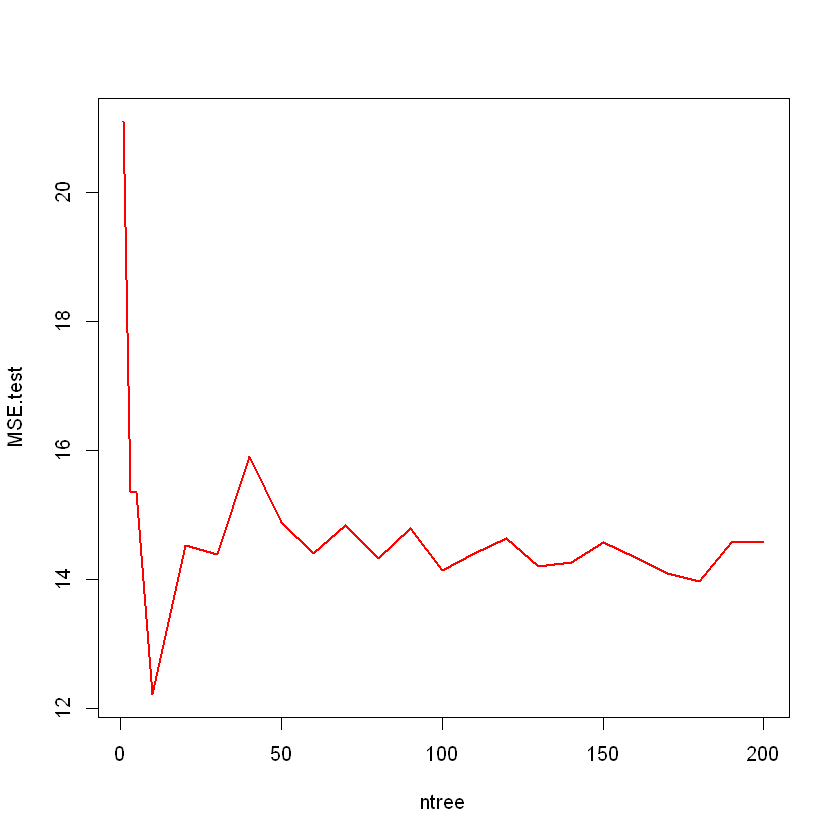

In [48]:
ntree<- c(1, 3, 5, seq(10, 200, 10))
MSE.test<- rep(0, length(ntree))
for(i in 1:length(ntree)){
  boston.bag1<- bagging(medv~., data = boston.train, nbagg=ntree[i])
  boston.bag.pred1<- predict(boston.bag1, newdata = boston.test)
  MSE.test[i]<- mean((boston.test$medv-boston.bag.pred1)^2)
}
plot(ntree, MSE.test, type = 'l', col=2, lwd=2)
rm(boston.bag1,boston.bag.pred1)

> **Notar que a mayor cantidad de árboles llega un punto donde su ganancia marginal es nula. Además, ingresar
demasiados árboles tiende a sobreajustarse a la base de entrenamiento, lo que perjudicaría el modelo y su capacidad de
adaptarse a nuevos datos.**

### Out-of-bag (OOB)
OOB es una forma de validar un modelo de Random Forest. En cada iteración de Bootstrap, las muestras no usadas
servirán para testear el modelo. Finalmente, se muestra el MSE disminuído.

In [49]:
boston.bag.oob<- bagging(medv~., data = boston.train, coob=T, nbagg=100)
boston.bag.oob # coob=T significa que sea TRUE el uso de OOB
rm(boston.bag.oob)


Bagging regression trees with 100 bootstrap replications 

Call: bagging.data.frame(formula = medv ~ ., data = boston.train, coob = T, 
    nbagg = 100)

Out-of-bag estimate of root mean squared error:  4.2551 


## RANDOM FOREST 

Random Forest es un derivado del Bagging, y mejora significativamente la predicción. La idea es que, aleatoriamente, se
selecciona un subconjunto de predictores como variables candidatas en cada separación del árbol. La razón de esto es
adaptarse a las correlaciónes naturales entre las variables y los árboles, así se reduce la varianza al agregar árboles.

In [50]:
library(randomForest)
boston.rf<- randomForest(medv~., data = boston.train, importance=TRUE)
boston.rf


Call:
 randomForest(formula = medv ~ ., data = boston.train, importance = TRUE) 
               Type of random forest: regression
                     Number of trees: 500
No. of variables tried at each split: 4

          Mean of squared residuals: 12.50255
                    % Var explained: 85.06

Por defecto, el modelo de árbol de regresión utiliza un tercio de las variables como predictoras en cada iteración.
Mientras que utiliza la raíz de las variables para las el problema de clasificación poor defecto. En ambos casos se puede
cambiar modificando el hyperparámetro **mtry=**. También se puede especificar el número de árboles con el hyperparámetro **ntree=**. por defecto se utilizan 500. El argumento **importance=TRUE** nos permite ver la importancia de cada variable en el modelo.

#### Tabla con Feature Importances


In [51]:
tabla<- rownames_to_column(data.frame(boston.rf$importance),"Variable")
tabla

Variable,X.IncMSE,IncNodePurity
<chr>,<dbl>,<dbl>
crim,7.6486481,1722.89516
zn,0.9453036,277.94043
indus,8.4174948,2163.93997
chas,0.1716375,64.33896
nox,10.9156503,2166.44884
rm,35.4212732,8856.93299
age,5.2684310,979.69613
dis,5.7751579,1547.28728
rad,1.5132440,320.90579


#### Gráfico con Feature Importances

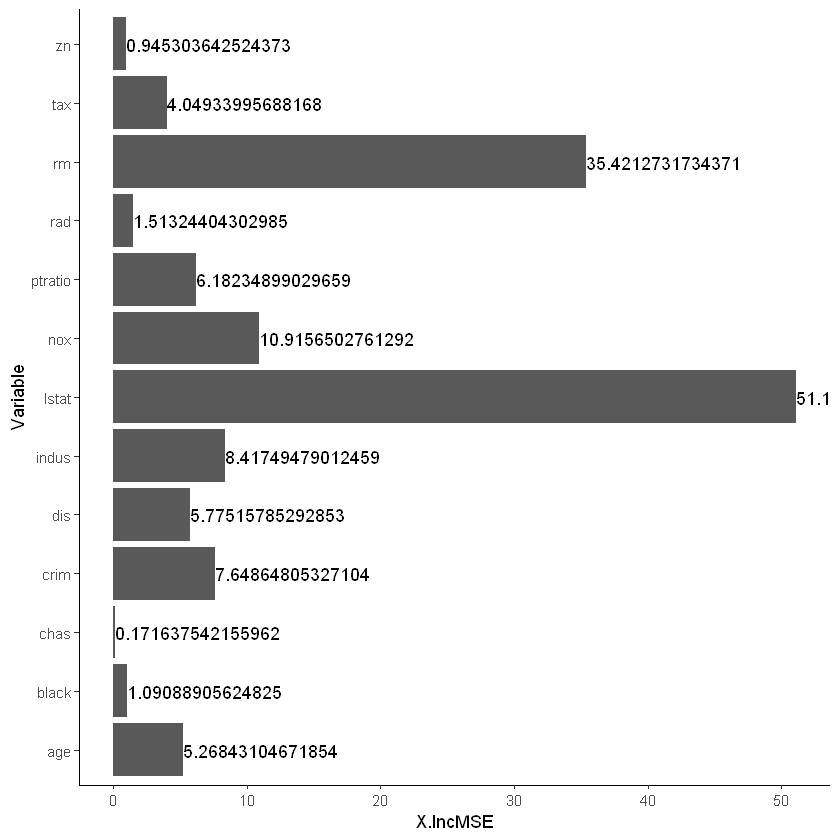

In [52]:
tabla %>% ggplot(aes(y=X.IncMSE,x=Variable))+geom_bar(stat="identity")+
  coord_flip()+theme_classic()+ 
  geom_text(aes(x=Variable,y=X.IncMSE,label=X.IncMSE),hjust=0)

**OBB y RANDOM FOREST**

El Random Forest guarda todos los errores del OOB para cada ntree desde 1 a 500. podemos graficarlo para ver cómo el
error OOB cambia según el número de árboles ntree.

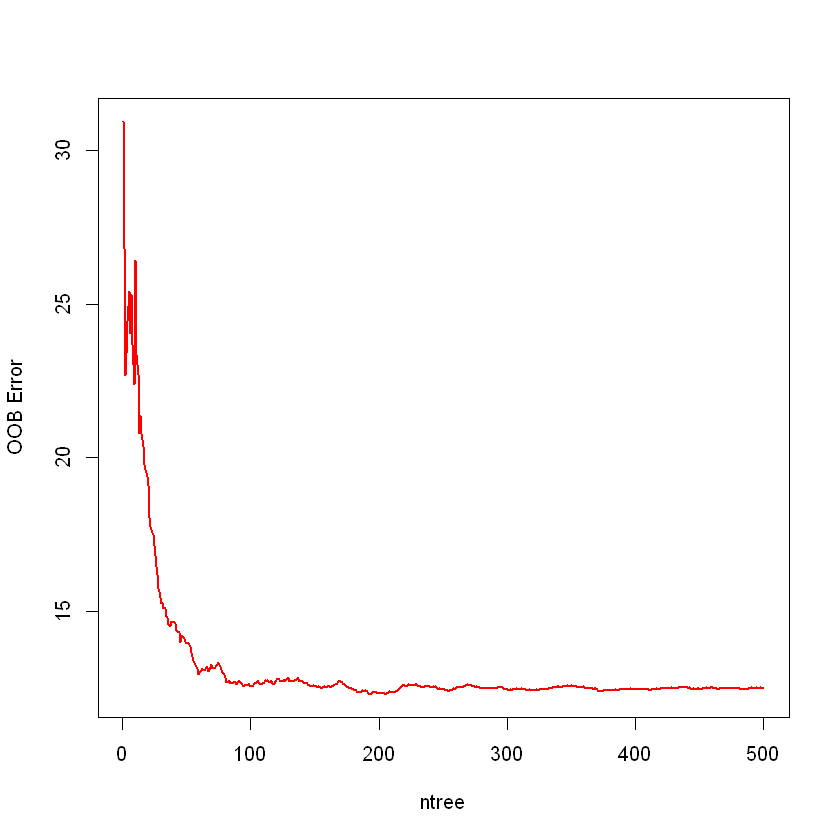

In [53]:
plot(boston.rf$mse, type='l', col=2, lwd=2, xlab = "ntree", ylab = "OOB Error")

Podemos ver el error al aplicar el modelo en la base test

In [55]:
boston.rf.pred<- predict(boston.rf, boston.test)
mean((boston.test$medv-boston.rf.pred)^2)
rm(boston.rf)

[1] 10.71696

Como se dijo previamente, el número de variables candidatas en cada iteración o separación es la raíz de las variables
totales: Si son 13 variables, m~4. También podemos especificar este número en el argumento **mtry=**. Ahora podemos
graficar las diferencias del error en OOB y el testing y como éstos cambian según el hyperparametro **mtry=**

1  2  3  4  5  6  7  8  9  10  11  12  13  

ERROR: Error in matplot(cbind(test.err, oob.err), pch = 15, col = c("red", "blue"), : argumento no-numérico para operador binario


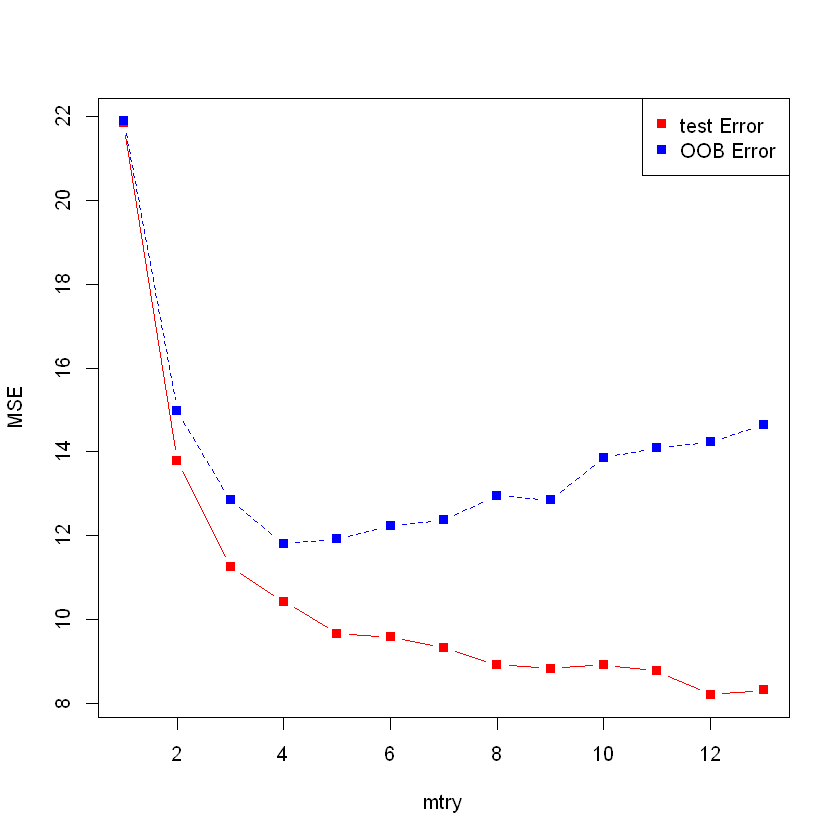

In [57]:
oob.err<- rep(0, 13)
test.err<- rep(0, 13)
for(i in 1:13){
  fit<- randomForest(medv~., data = boston.train, mtry=i)
  oob.err[i]<- fit$mse[500]
  test.err[i]<- mean((boston.test$medv-predict(fit, boston.test))^2)
  cat(i, " ")
}
matplot(cbind(test.err, oob.err), pch=15, col = c("red", "blue"), type = "b", ylab = "MSE", xlab = "mtry")+
  legend("topright", legend = c("test Error", "OOB Error"), pch = 15, col = c("red", "blue"))

## BOOSTING
Consiste en ajustar secuencialmente múltiples modelos sencillos, llamados weak learners, de forma que cada modelo
aprende de los errores del anterior. Como valor final, al igual que en bagging, se toma la media de todas las predicciones
(variables continuas) o la clase más frecuente (variables cualitativas). Tres de los métodos de boosting más empleados
son AdaBoost, Gradient Boosting y * Stochastic Gradient Boosting*.

In [58]:
install.packages("gbm")
library(gbm)

Installing package into 'C:/Users/feseg/OneDrive/Documentos/R/win-library/3.6'
(as 'lib' is unspecified)


package 'gbm' successfully unpacked and MD5 sums checked


Warning message:
"cannot remove prior installation of package 'gbm'"Warning message in file.copy(savedcopy, lib, recursive = TRUE):
"problema al copiar C:\Users\feseg\OneDrive\Documentos\R\win-library\3.6\00LOCK\gbm\libs\x64\gbm.dll  a C:\Users\feseg\OneDrive\Documentos\R\win-library\3.6\gbm\libs\x64\gbm.dll: Permission denied"Warning message:
"restored 'gbm'"


The downloaded binary packages are in
	C:\Users\feseg\AppData\Local\Temp\RtmpqqKUbs\downloaded_packages


Loaded gbm 2.1.5


,var,rel.inf
,<fct>,<dbl>
lstat,lstat,35.05254078
rm,rm,33.46763381
dis,dis,7.43413837
nox,nox,5.14080480
crim,crim,4.88776641
age,age,3.85606598
ptratio,ptratio,2.99971204
black,black,2.70122402
tax,tax,2.32318795


[1] 9.184468

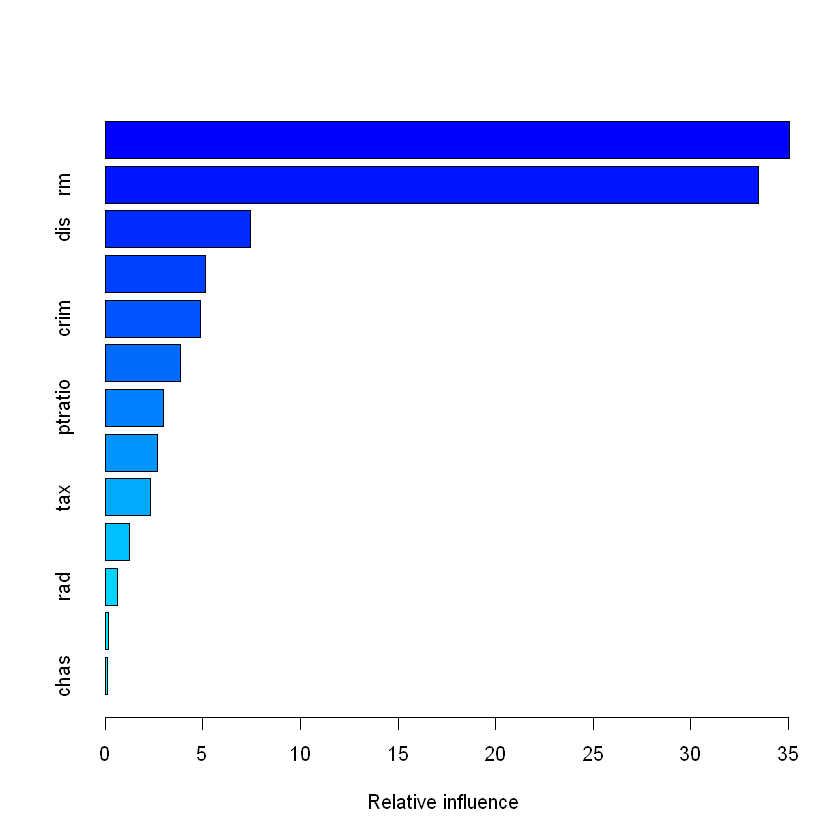

In [59]:
boston.boost<- gbm(medv~., data = boston.train, distribution = "gaussian",
                   n.trees = 10000, shrinkage = 0.01, interaction.depth = 8)
summary(boston.boost)

boston.boost.pred.test<- predict(boston.boost, boston.test, n.trees = 10000)
mean((boston.test$medv-boston.boost.pred.test)^2)

Notar que debemos especificar el tipo de distribución en distribution = **“gaussian”** al trabajar en árboles de regresión.
Por defecto esto trabaja en distribución **Bernoulli** para clasificación binaria. 

- **n.trees** corresponde al número de árboles a ajustar. A mayor n.trees podría haber mayor sobreajuste. 
- **shrinkage** es un argumento para decidir cuanta contribución aporta cada nuevo árbol al modelo. 
- **interaction.depth** es cuantas separaciones tendrá cada árbol. 

La mejor  manera de ajustar estos parámetros es mediante Validación cruzada y grid search (que se verá en la respectiva ayudantía).

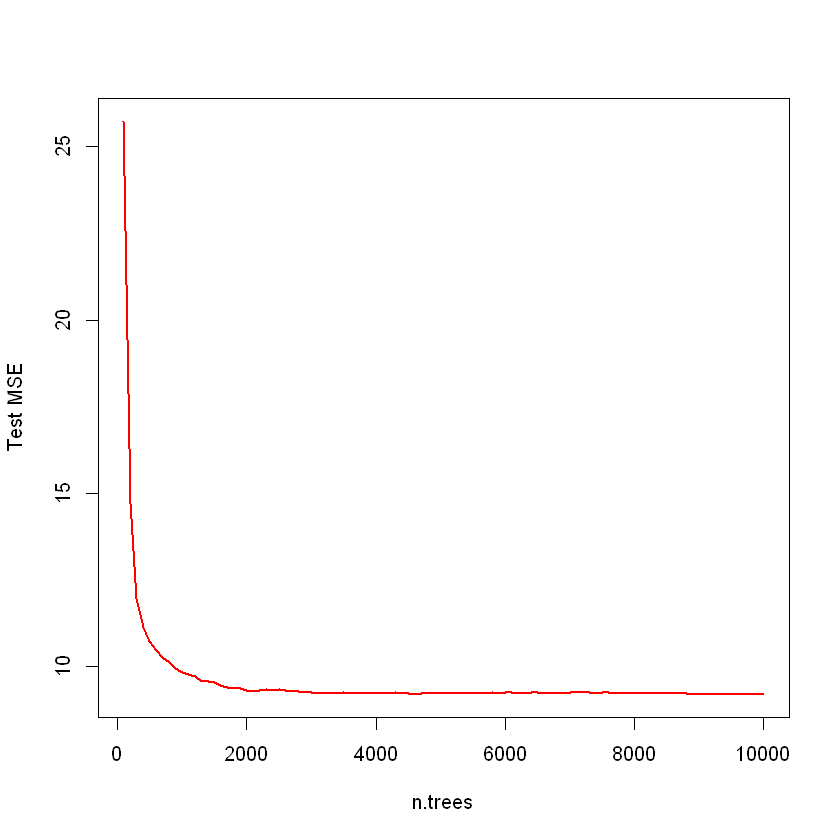

In [61]:
ntree<- seq(100, 10000, 100)
predmat<- predict(boston.boost, newdata = boston.test, n.trees = ntree)
err<- apply((predmat-boston.test$medv)^2, 2, mean)
plot(ntree, err, type = 'l', col=2, lwd=2, xlab = "n.trees", ylab = "Test MSE")
abline(h=min(test.err), lty=2)

## 2) GRID SEARCH


El paquete caret R proporciona un Gridsearch donde puede especificar los parámetros para tratar su problema. Y probará todas las combinaciones y localizará la combinación que ofrezca los mejores resultados. No todos los algoritmos de aprendizaje automático están disponibles para el ajuste
En https://topepo.github.io/caret/available-models.html pueden verificar que parametros del modelo de caret se pueden ajustar

### Cargar librerias

In [73]:
#install.packages("mlbench")
#install.packages("caret")
#install.packages("e1071")
library(mlbench)
library(caret)
library(e1071)
set.seed(1)


### Cargamos la base
Particionamos la base en training y testing

DADO QUE LAS ETAPAS DE PREPROCESAMIENTO Y TRANSFORMACION NO SON EL FOCO DE ESTA AYUDANTIA SERAN OMITIDAS.


In [74]:

data(Sonar)
Base <- Sonar
Variables <- Base[,1:60]
Clase <- Base[,61]

inTraining <- createDataPartition(Base$Class, p = .70, list =FALSE)

#Training corresponde al 70% de la base train
training <- Base[inTraining,]

#Testing corresponde al restante 30% de la base train
testing  <- Base[-inTraining,]


### Exploración de la base

In [75]:
head(Sonar)

V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V52,V53,V54,V55,V56,V57,V58,V59,V60,Class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R
0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R
0.0286,0.0453,0.0277,0.0174,0.0384,0.0990,0.1201,0.1833,0.2105,0.3039,...,0.0045,0.0014,0.0038,0.0013,0.0089,0.0057,0.0027,0.0051,0.0062,R


## Primera opción de Grid Search: Automatic Grid

Permite que el sistema lo haga automáticamente. 
Esto se puede hacer configurando **tuneLength** para indicar el número de valores diferentes para probar para cada parámetro del algoritmo.

**OJO**: ESTE MÉTODO PUEDE TOMAR ARTO TIEMPO COMPUTACIONAL Y EN ESPECIAL CUANDO ELIGEN UN **tunelength** MUY GRANDE


### MODELO SVM 
El modelo **svmPoly** tiene como parametros:  degree, scale, C

C: es el parámetro de regularización, C, del término de error es el grado de la función del núcleo polinomial ('poli') y es ignorado por todos los demás núcleos. El valor predeterminado es 3.

- El código en la celda a continuación utiliza la capacidad del paquete R Caret para estimar los mejores hiperparámetros usando la validación cruzada 5 veces. Esta primera validación cruzada se realiza utilizando ROC como la métrica. Hay algunos puntos a tener en cuenta aquí:
- **trainControl** se utiliza para definir el entrenamiento. Por ejemplo: 
    - `method = cv` corresponde a la cross-validation y `number=10` corresponde a 10 fold.
    - Se especifica la función `twoClassSummary`, lo que convierte a ROC en la métrica para la optimización de hiperparámetros.
    - El argumento `tuneLength` le dice al algoritmo que pruebe diferentes valores predeterminados para el parámetro principal

In [109]:
control_svm <- trainControl(method='cv', 
                        number=10,
                            
                        verboseIter = TRUE,
                        summaryFunction = twoClassSummary,
                        classProbs = TRUE)
# Entrenamiento de la base training utilizando el metodo de support vector machine con AUTOMATIC GRID
model_SVM_AG <- train(
  Class ~ ., training,
  method = "svmPoly",
  trControl = control_svm,
  tuneLength = 6,
  metric ="ROC"
  )





+ Fold01: degree=1, scale=1e-03, C=0.25 
- Fold01: degree=1, scale=1e-03, C=0.25 
+ Fold01: degree=2, scale=1e-03, C=0.25 
- Fold01: degree=2, scale=1e-03, C=0.25 
+ Fold01: degree=3, scale=1e-03, C=0.25 
- Fold01: degree=3, scale=1e-03, C=0.25 
+ Fold01: degree=1, scale=1e-02, C=0.25 
- Fold01: degree=1, scale=1e-02, C=0.25 
+ Fold01: degree=2, scale=1e-02, C=0.25 
- Fold01: degree=2, scale=1e-02, C=0.25 
+ Fold01: degree=3, scale=1e-02, C=0.25 
- Fold01: degree=3, scale=1e-02, C=0.25 
+ Fold01: degree=1, scale=1e-01, C=0.25 
- Fold01: degree=1, scale=1e-01, C=0.25 
+ Fold01: degree=2, scale=1e-01, C=0.25 
- Fold01: degree=2, scale=1e-01, C=0.25 
+ Fold01: degree=3, scale=1e-01, C=0.25 
- Fold01: degree=3, scale=1e-01, C=0.25 
+ Fold01: degree=1, scale=1e+00, C=0.25 
- Fold01: degree=1, scale=1e+00, C=0.25 
+ Fold01: degree=2, scale=1e+00, C=0.25 
- Fold01: degree=2, scale=1e+00, C=0.25 
+ Fold01: degree=3, scale=1e+00, C=0.25 
- Fold01: degree=3, scale=1e+00, C=0.25 
+ Fold01: degree

Se grafican los desempeños de las distintas configuraciones probadas

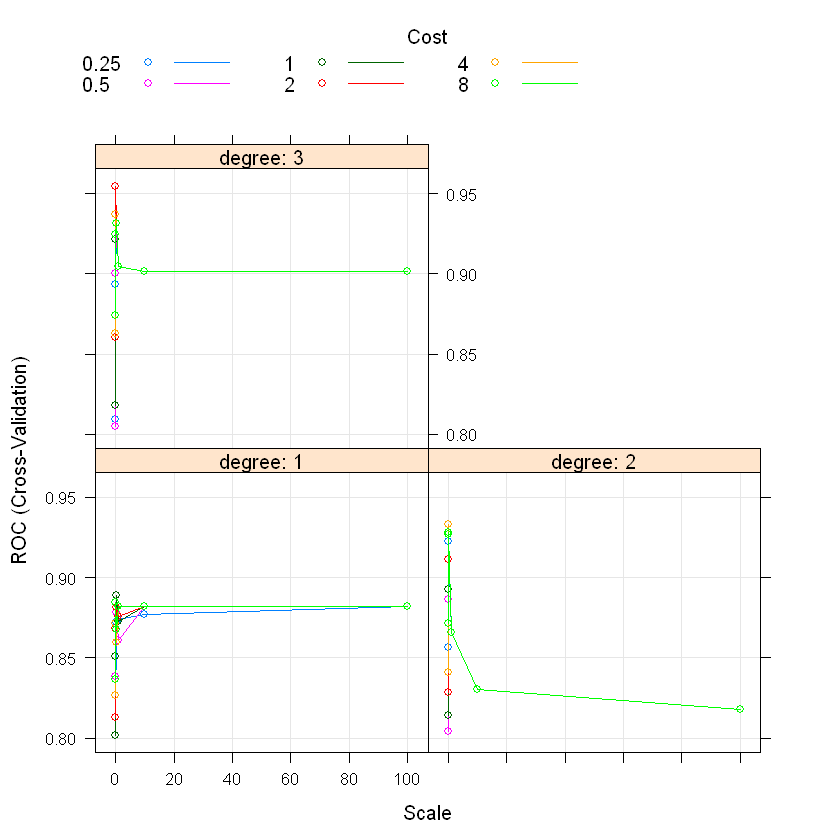

In [111]:
plot(model_SVM_AG)

Se imprime las métricas de las distintas combinaciones de parámetros

In [112]:
print(model_SVM_AG)

Support Vector Machines with Polynomial Kernel 

146 samples
 60 predictor
  2 classes: 'M', 'R' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 131, 132, 131, 131, 131, 131, ... 
Resampling results across tuning parameters:

  degree  scale  C     ROC        Sens       Spec     
  1       1e-03  0.25  0.8016582  0.5250000  0.8547619
  1       1e-03  0.50  0.8016582  0.5125000  0.8547619
  1       1e-03  1.00  0.8016582  0.4750000  0.8547619
  1       1e-03  2.00  0.8127551  0.7285714  0.7285714
  1       1e-03  4.00  0.8265306  0.7285714  0.7000000
  1       1e-03  8.00  0.8364371  0.7928571  0.7285714
  1       1e-02  0.25  0.8130952  0.7553571  0.7142857
  1       1e-02  0.50  0.8384354  0.7428571  0.7571429
  1       1e-02  1.00  0.8507228  0.7678571  0.7285714
  1       1e-02  2.00  0.8682398  0.7821429  0.7904762
  1       1e-02  4.00  0.8711735  0.7964286  0.7928571
  1       1e-02  8.00  0.8844813  0.8482143  0.7928571
  1       1e-01  0.25  

La mejor configuración del modelo con automatic grid es **degree = 3, scale = 0.01 and C = 2**


In [119]:
model_SVM <- train(
  Class ~ ., training,
  method = "svmPoly",
    metric ="ROC",
  trControl = trainControl(
    method = "cv", number = 10,
    verboseIter = TRUE,
      summaryFunction = twoClassSummary,
                        classProbs = TRUE
  )
)



+ Fold01: degree=1, scale=0.001, C=0.25 
- Fold01: degree=1, scale=0.001, C=0.25 
+ Fold01: degree=2, scale=0.001, C=0.25 
- Fold01: degree=2, scale=0.001, C=0.25 
+ Fold01: degree=3, scale=0.001, C=0.25 
- Fold01: degree=3, scale=0.001, C=0.25 
+ Fold01: degree=1, scale=0.010, C=0.25 
- Fold01: degree=1, scale=0.010, C=0.25 
+ Fold01: degree=2, scale=0.010, C=0.25 
- Fold01: degree=2, scale=0.010, C=0.25 
+ Fold01: degree=3, scale=0.010, C=0.25 
- Fold01: degree=3, scale=0.010, C=0.25 
+ Fold01: degree=1, scale=0.100, C=0.25 
- Fold01: degree=1, scale=0.100, C=0.25 
+ Fold01: degree=2, scale=0.100, C=0.25 
- Fold01: degree=2, scale=0.100, C=0.25 
+ Fold01: degree=3, scale=0.100, C=0.25 
- Fold01: degree=3, scale=0.100, C=0.25 
+ Fold01: degree=1, scale=0.001, C=0.50 
- Fold01: degree=1, scale=0.001, C=0.50 
+ Fold01: degree=2, scale=0.001, C=0.50 
- Fold01: degree=2, scale=0.001, C=0.50 
+ Fold01: degree=3, scale=0.001, C=0.50 
- Fold01: degree=3, scale=0.001, C=0.50 
+ Fold01: degree

In [120]:
#Aplicar el modelo en la base testing
print("MODELO NORMAL")
SVMprediction <-predict(model_SVM, testing)
cmSVM <-confusionMatrix(SVMprediction,testing$Class)
print(cmSVM)
print("MODELO CON AUTOMATIC GRID")
SVM_AG_predict <-predict(model_SVM_AG, testing)
cmSVM_AG1 <-confusionMatrix(SVM_AG_predict,testing$Class)
print(cmSVM_AG1)

[1] "MODELO NORMAL"
Confusion Matrix and Statistics

          Reference
Prediction  M  R
         M 29  6
         R  4 23
                                          
               Accuracy : 0.8387          
                 95% CI : (0.7233, 0.9198)
    No Information Rate : 0.5323          
    P-Value [Acc > NIR] : 3.903e-07       
                                          
                  Kappa : 0.6747          
                                          
 Mcnemar's Test P-Value : 0.7518          
                                          
            Sensitivity : 0.8788          
            Specificity : 0.7931          
         Pos Pred Value : 0.8286          
         Neg Pred Value : 0.8519          
             Prevalence : 0.5323          
         Detection Rate : 0.4677          
   Detection Prevalence : 0.5645          
      Balanced Accuracy : 0.8359          
                                          
       'Positive' Class : M               
                

Como podemos notar el modelo con automatic grid tiene una mejor performance

### MODELO DECISSION TREE

- A diferencia del modelo SVM ahora compararemos dos modelos DT, uno sin GridSearch y uno con GridSearch
- Parametros del DT C50 son trials, model, winnow

Primero definimos los fold y las repeticiones del crossvalidation
Usaremos el método **repeatedcv** que es un cross validation repetido segun la cantidad de **repeats** ingresadas. 


In [121]:
Control_DT_c50 <- trainControl(method = "repeatedcv",
                           number = 10,
                           repeats = 3,verboseIter = TRUE,
                           summaryFunction = twoClassSummary,
                           classProbs = TRUE)

In [122]:
#Modelo DT Original
model_DT <- train(
  Class ~ ., training,
  method = "C5.0",
  metric = "ROC",
  trControl = trainControl(
    method = "cv", number = 10,
    verboseIter = TRUE,
    summaryFunction = twoClassSummary,
    classProbs = TRUE))

#Modelo DT con GridSearch
model_DT_1 <- train(
  Class ~ ., training,
  method = "C5.0",
  trControl = Control_DT_c50, 
  tuneLength = 10,
  metric ="ROC")
    

+ Fold01: model=tree, winnow=FALSE, trials=20 
- Fold01: model=tree, winnow=FALSE, trials=20 
+ Fold01: model=tree, winnow= TRUE, trials=20 


Warning message:
"'trials' should be <= 5 for this object. Predictions generated using 5 trials"Warning message:
"'trials' should be <= 5 for this object. Predictions generated using 5 trials"

- Fold01: model=tree, winnow= TRUE, trials=20 
+ Fold01: model=rules, winnow=FALSE, trials=20 
- Fold01: model=rules, winnow=FALSE, trials=20 
+ Fold01: model=rules, winnow= TRUE, trials=20 


Warning message:
"'trials' should be <= 5 for this object. Predictions generated using 5 trials"Warning message:
"'trials' should be <= 5 for this object. Predictions generated using 5 trials"

- Fold01: model=rules, winnow= TRUE, trials=20 
+ Fold02: model=tree, winnow=FALSE, trials=20 


Warning message:
"'trials' should be <= 1 for this object. Predictions generated using 1 trials"Warning message:
"'trials' should be <= 1 for this object. Predictions generated using 1 trials"

- Fold02: model=tree, winnow=FALSE, trials=20 
+ Fold02: model=tree, winnow= TRUE, trials=20 


Warning message:
"'trials' should be <= 8 for this object. Predictions generated using 8 trials"Warning message:
"'trials' should be <= 8 for this object. Predictions generated using 8 trials"

- Fold02: model=tree, winnow= TRUE, trials=20 
+ Fold02: model=rules, winnow=FALSE, trials=20 
- Fold02: model=rules, winnow=FALSE, trials=20 
+ Fold02: model=rules, winnow= TRUE, trials=20 
- Fold02: model=rules, winnow= TRUE, trials=20 
+ Fold03: model=tree, winnow=FALSE, trials=20 
- Fold03: model=tree, winnow=FALSE, trials=20 
+ Fold03: model=tree, winnow= TRUE, trials=20 


Warning message:
"'trials' should be <= 3 for this object. Predictions generated using 3 trials"Warning message:
"'trials' should be <= 3 for this object. Predictions generated using 3 trials"

- Fold03: model=tree, winnow= TRUE, trials=20 
+ Fold03: model=rules, winnow=FALSE, trials=20 
- Fold03: model=rules, winnow=FALSE, trials=20 
+ Fold03: model=rules, winnow= TRUE, trials=20 


Warning message:
"'trials' should be <= 3 for this object. Predictions generated using 3 trials"Warning message:
"'trials' should be <= 3 for this object. Predictions generated using 3 trials"

- Fold03: model=rules, winnow= TRUE, trials=20 
+ Fold04: model=tree, winnow=FALSE, trials=20 
- Fold04: model=tree, winnow=FALSE, trials=20 
+ Fold04: model=tree, winnow= TRUE, trials=20 
- Fold04: model=tree, winnow= TRUE, trials=20 
+ Fold04: model=rules, winnow=FALSE, trials=20 
- Fold04: model=rules, winnow=FALSE, trials=20 
+ Fold04: model=rules, winnow= TRUE, trials=20 


Warning message:
"'trials' should be <= 5 for this object. Predictions generated using 5 trials"Warning message:
"'trials' should be <= 5 for this object. Predictions generated using 5 trials"

- Fold04: model=rules, winnow= TRUE, trials=20 
+ Fold05: model=tree, winnow=FALSE, trials=20 
- Fold05: model=tree, winnow=FALSE, trials=20 
+ Fold05: model=tree, winnow= TRUE, trials=20 


Warning message:
"'trials' should be <= 9 for this object. Predictions generated using 9 trials"Warning message:
"'trials' should be <= 9 for this object. Predictions generated using 9 trials"

- Fold05: model=tree, winnow= TRUE, trials=20 
+ Fold05: model=rules, winnow=FALSE, trials=20 
- Fold05: model=rules, winnow=FALSE, trials=20 
+ Fold05: model=rules, winnow= TRUE, trials=20 
- Fold05: model=rules, winnow= TRUE, trials=20 
+ Fold06: model=tree, winnow=FALSE, trials=20 
- Fold06: model=tree, winnow=FALSE, trials=20 
+ Fold06: model=tree, winnow= TRUE, trials=20 


Warning message:
"'trials' should be <= 1 for this object. Predictions generated using 1 trials"Warning message:
"'trials' should be <= 1 for this object. Predictions generated using 1 trials"

- Fold06: model=tree, winnow= TRUE, trials=20 
+ Fold06: model=rules, winnow=FALSE, trials=20 
- Fold06: model=rules, winnow=FALSE, trials=20 
+ Fold06: model=rules, winnow= TRUE, trials=20 


Warning message:
"'trials' should be <= 1 for this object. Predictions generated using 1 trials"Warning message:
"'trials' should be <= 1 for this object. Predictions generated using 1 trials"

- Fold06: model=rules, winnow= TRUE, trials=20 
+ Fold07: model=tree, winnow=FALSE, trials=20 
- Fold07: model=tree, winnow=FALSE, trials=20 
+ Fold07: model=tree, winnow= TRUE, trials=20 


Warning message:
"'trials' should be <= 1 for this object. Predictions generated using 1 trials"Warning message:
"'trials' should be <= 1 for this object. Predictions generated using 1 trials"

- Fold07: model=tree, winnow= TRUE, trials=20 
+ Fold07: model=rules, winnow=FALSE, trials=20 
- Fold07: model=rules, winnow=FALSE, trials=20 
+ Fold07: model=rules, winnow= TRUE, trials=20 


Warning message:
"'trials' should be <= 1 for this object. Predictions generated using 1 trials"Warning message:
"'trials' should be <= 1 for this object. Predictions generated using 1 trials"

- Fold07: model=rules, winnow= TRUE, trials=20 
+ Fold08: model=tree, winnow=FALSE, trials=20 
- Fold08: model=tree, winnow=FALSE, trials=20 
+ Fold08: model=tree, winnow= TRUE, trials=20 
- Fold08: model=tree, winnow= TRUE, trials=20 
+ Fold08: model=rules, winnow=FALSE, trials=20 
- Fold08: model=rules, winnow=FALSE, trials=20 
+ Fold08: model=rules, winnow= TRUE, trials=20 
- Fold08: model=rules, winnow= TRUE, trials=20 
+ Fold09: model=tree, winnow=FALSE, trials=20 
- Fold09: model=tree, winnow=FALSE, trials=20 
+ Fold09: model=tree, winnow= TRUE, trials=20 


Warning message:
"'trials' should be <= 5 for this object. Predictions generated using 5 trials"Warning message:
"'trials' should be <= 5 for this object. Predictions generated using 5 trials"

- Fold09: model=tree, winnow= TRUE, trials=20 
+ Fold09: model=rules, winnow=FALSE, trials=20 
- Fold09: model=rules, winnow=FALSE, trials=20 
+ Fold09: model=rules, winnow= TRUE, trials=20 


Warning message:
"'trials' should be <= 5 for this object. Predictions generated using 5 trials"Warning message:
"'trials' should be <= 5 for this object. Predictions generated using 5 trials"

- Fold09: model=rules, winnow= TRUE, trials=20 
+ Fold10: model=tree, winnow=FALSE, trials=20 
- Fold10: model=tree, winnow=FALSE, trials=20 
+ Fold10: model=tree, winnow= TRUE, trials=20 


Warning message:
"'trials' should be <= 3 for this object. Predictions generated using 3 trials"Warning message:
"'trials' should be <= 3 for this object. Predictions generated using 3 trials"

- Fold10: model=tree, winnow= TRUE, trials=20 
+ Fold10: model=rules, winnow=FALSE, trials=20 
- Fold10: model=rules, winnow=FALSE, trials=20 
+ Fold10: model=rules, winnow= TRUE, trials=20 


Warning message:
"'trials' should be <= 3 for this object. Predictions generated using 3 trials"Warning message:
"'trials' should be <= 3 for this object. Predictions generated using 3 trials"

- Fold10: model=rules, winnow= TRUE, trials=20 
Aggregating results
Selecting tuning parameters
Fitting trials = 10, model = tree, winnow = FALSE on full training set
+ Fold01.Rep1: model=tree, winnow=FALSE, trials=90 
- Fold01.Rep1: model=tree, winnow=FALSE, trials=90 
+ Fold01.Rep1: model=tree, winnow= TRUE, trials=90 


Warning message:
"'trials' should be <= 1 for this object. Predictions generated using 1 trials"Warning message:
"'trials' should be <= 1 for this object. Predictions generated using 1 trials"Warning message:
"'trials' should be <= 1 for this object. Predictions generated using 1 trials"Warning message:
"'trials' should be <= 1 for this object. Predictions generated using 1 trials"Warning message:
"'trials' should be <= 1 for this object. Predictions generated using 1 trials"Warning message:
"'trials' should be <= 1 for this object. Predictions generated using 1 trials"Warning message:
"'trials' should be <= 1 for this object. Predictions generated using 1 trials"Warning message:
"'trials' should be <= 1 for this object. Predictions generated using 1 trials"Warning message:
"'trials' should be <= 1 for this object. Predictions generated using 1 trials"Warning message:
"'trials' should be <= 1 for this object. Predictions generated using 1 trials"Warning message:
"'trials' should be <= 

- Fold01.Rep1: model=tree, winnow= TRUE, trials=90 
+ Fold01.Rep1: model=rules, winnow=FALSE, trials=90 
- Fold01.Rep1: model=rules, winnow=FALSE, trials=90 
+ Fold01.Rep1: model=rules, winnow= TRUE, trials=90 


Warning message:
"'trials' should be <= 1 for this object. Predictions generated using 1 trials"Warning message:
"'trials' should be <= 1 for this object. Predictions generated using 1 trials"Warning message:
"'trials' should be <= 1 for this object. Predictions generated using 1 trials"Warning message:
"'trials' should be <= 1 for this object. Predictions generated using 1 trials"Warning message:
"'trials' should be <= 1 for this object. Predictions generated using 1 trials"Warning message:
"'trials' should be <= 1 for this object. Predictions generated using 1 trials"Warning message:
"'trials' should be <= 1 for this object. Predictions generated using 1 trials"Warning message:
"'trials' should be <= 1 for this object. Predictions generated using 1 trials"Warning message:
"'trials' should be <= 1 for this object. Predictions generated using 1 trials"Warning message:
"'trials' should be <= 1 for this object. Predictions generated using 1 trials"Warning message:
"'trials' should be <= 

- Fold01.Rep1: model=rules, winnow= TRUE, trials=90 
+ Fold02.Rep1: model=tree, winnow=FALSE, trials=90 
- Fold02.Rep1: model=tree, winnow=FALSE, trials=90 
+ Fold02.Rep1: model=tree, winnow= TRUE, trials=90 


Warning message:
"'trials' should be <= 3 for this object. Predictions generated using 3 trials"Warning message:
"'trials' should be <= 3 for this object. Predictions generated using 3 trials"Warning message:
"'trials' should be <= 3 for this object. Predictions generated using 3 trials"Warning message:
"'trials' should be <= 3 for this object. Predictions generated using 3 trials"Warning message:
"'trials' should be <= 3 for this object. Predictions generated using 3 trials"Warning message:
"'trials' should be <= 3 for this object. Predictions generated using 3 trials"Warning message:
"'trials' should be <= 3 for this object. Predictions generated using 3 trials"Warning message:
"'trials' should be <= 3 for this object. Predictions generated using 3 trials"Warning message:
"'trials' should be <= 3 for this object. Predictions generated using 3 trials"Warning message:
"'trials' should be <= 3 for this object. Predictions generated using 3 trials"Warning message:
"'trials' should be <= 

- Fold02.Rep1: model=tree, winnow= TRUE, trials=90 
+ Fold02.Rep1: model=rules, winnow=FALSE, trials=90 
- Fold02.Rep1: model=rules, winnow=FALSE, trials=90 
+ Fold02.Rep1: model=rules, winnow= TRUE, trials=90 


Warning message:
"'trials' should be <= 3 for this object. Predictions generated using 3 trials"Warning message:
"'trials' should be <= 3 for this object. Predictions generated using 3 trials"Warning message:
"'trials' should be <= 3 for this object. Predictions generated using 3 trials"Warning message:
"'trials' should be <= 3 for this object. Predictions generated using 3 trials"Warning message:
"'trials' should be <= 3 for this object. Predictions generated using 3 trials"Warning message:
"'trials' should be <= 3 for this object. Predictions generated using 3 trials"Warning message:
"'trials' should be <= 3 for this object. Predictions generated using 3 trials"Warning message:
"'trials' should be <= 3 for this object. Predictions generated using 3 trials"Warning message:
"'trials' should be <= 3 for this object. Predictions generated using 3 trials"Warning message:
"'trials' should be <= 3 for this object. Predictions generated using 3 trials"Warning message:
"'trials' should be <= 

- Fold02.Rep1: model=rules, winnow= TRUE, trials=90 
+ Fold03.Rep1: model=tree, winnow=FALSE, trials=90 
- Fold03.Rep1: model=tree, winnow=FALSE, trials=90 
+ Fold03.Rep1: model=tree, winnow= TRUE, trials=90 


Warning message:
"'trials' should be <= 1 for this object. Predictions generated using 1 trials"Warning message:
"'trials' should be <= 1 for this object. Predictions generated using 1 trials"Warning message:
"'trials' should be <= 1 for this object. Predictions generated using 1 trials"Warning message:
"'trials' should be <= 1 for this object. Predictions generated using 1 trials"Warning message:
"'trials' should be <= 1 for this object. Predictions generated using 1 trials"Warning message:
"'trials' should be <= 1 for this object. Predictions generated using 1 trials"Warning message:
"'trials' should be <= 1 for this object. Predictions generated using 1 trials"Warning message:
"'trials' should be <= 1 for this object. Predictions generated using 1 trials"Warning message:
"'trials' should be <= 1 for this object. Predictions generated using 1 trials"Warning message:
"'trials' should be <= 1 for this object. Predictions generated using 1 trials"Warning message:
"'trials' should be <= 

- Fold03.Rep1: model=tree, winnow= TRUE, trials=90 
+ Fold03.Rep1: model=rules, winnow=FALSE, trials=90 
- Fold03.Rep1: model=rules, winnow=FALSE, trials=90 
+ Fold03.Rep1: model=rules, winnow= TRUE, trials=90 


Warning message:
"'trials' should be <= 1 for this object. Predictions generated using 1 trials"Warning message:
"'trials' should be <= 1 for this object. Predictions generated using 1 trials"Warning message:
"'trials' should be <= 1 for this object. Predictions generated using 1 trials"Warning message:
"'trials' should be <= 1 for this object. Predictions generated using 1 trials"Warning message:
"'trials' should be <= 1 for this object. Predictions generated using 1 trials"Warning message:
"'trials' should be <= 1 for this object. Predictions generated using 1 trials"Warning message:
"'trials' should be <= 1 for this object. Predictions generated using 1 trials"Warning message:
"'trials' should be <= 1 for this object. Predictions generated using 1 trials"Warning message:
"'trials' should be <= 1 for this object. Predictions generated using 1 trials"Warning message:
"'trials' should be <= 1 for this object. Predictions generated using 1 trials"Warning message:
"'trials' should be <= 

- Fold03.Rep1: model=rules, winnow= TRUE, trials=90 
+ Fold04.Rep1: model=tree, winnow=FALSE, trials=90 
- Fold04.Rep1: model=tree, winnow=FALSE, trials=90 
+ Fold04.Rep1: model=tree, winnow= TRUE, trials=90 


Warning message:
"'trials' should be <= 11 for this object. Predictions generated using 11 trials"Warning message:
"'trials' should be <= 11 for this object. Predictions generated using 11 trials"Warning message:
"'trials' should be <= 11 for this object. Predictions generated using 11 trials"Warning message:
"'trials' should be <= 11 for this object. Predictions generated using 11 trials"Warning message:
"'trials' should be <= 11 for this object. Predictions generated using 11 trials"Warning message:
"'trials' should be <= 11 for this object. Predictions generated using 11 trials"Warning message:
"'trials' should be <= 11 for this object. Predictions generated using 11 trials"Warning message:
"'trials' should be <= 11 for this object. Predictions generated using 11 trials"Warning message:
"'trials' should be <= 11 for this object. Predictions generated using 11 trials"Warning message:
"'trials' should be <= 11 for this object. Predictions generated using 11 trials"Warning message:
"'t

- Fold04.Rep1: model=tree, winnow= TRUE, trials=90 
+ Fold04.Rep1: model=rules, winnow=FALSE, trials=90 
- Fold04.Rep1: model=rules, winnow=FALSE, trials=90 
+ Fold04.Rep1: model=rules, winnow= TRUE, trials=90 


Warning message:
"'trials' should be <= 9 for this object. Predictions generated using 9 trials"Warning message:
"'trials' should be <= 9 for this object. Predictions generated using 9 trials"Warning message:
"'trials' should be <= 9 for this object. Predictions generated using 9 trials"Warning message:
"'trials' should be <= 9 for this object. Predictions generated using 9 trials"Warning message:
"'trials' should be <= 9 for this object. Predictions generated using 9 trials"Warning message:
"'trials' should be <= 9 for this object. Predictions generated using 9 trials"Warning message:
"'trials' should be <= 9 for this object. Predictions generated using 9 trials"Warning message:
"'trials' should be <= 9 for this object. Predictions generated using 9 trials"Warning message:
"'trials' should be <= 9 for this object. Predictions generated using 9 trials"Warning message:
"'trials' should be <= 9 for this object. Predictions generated using 9 trials"Warning message:
"'trials' should be <= 

- Fold04.Rep1: model=rules, winnow= TRUE, trials=90 
+ Fold05.Rep1: model=tree, winnow=FALSE, trials=90 
- Fold05.Rep1: model=tree, winnow=FALSE, trials=90 
+ Fold05.Rep1: model=tree, winnow= TRUE, trials=90 


Warning message:
"'trials' should be <= 4 for this object. Predictions generated using 4 trials"Warning message:
"'trials' should be <= 4 for this object. Predictions generated using 4 trials"Warning message:
"'trials' should be <= 4 for this object. Predictions generated using 4 trials"Warning message:
"'trials' should be <= 4 for this object. Predictions generated using 4 trials"Warning message:
"'trials' should be <= 4 for this object. Predictions generated using 4 trials"Warning message:
"'trials' should be <= 4 for this object. Predictions generated using 4 trials"Warning message:
"'trials' should be <= 4 for this object. Predictions generated using 4 trials"Warning message:
"'trials' should be <= 4 for this object. Predictions generated using 4 trials"Warning message:
"'trials' should be <= 4 for this object. Predictions generated using 4 trials"Warning message:
"'trials' should be <= 4 for this object. Predictions generated using 4 trials"Warning message:
"'trials' should be <= 

- Fold05.Rep1: model=tree, winnow= TRUE, trials=90 
+ Fold05.Rep1: model=rules, winnow=FALSE, trials=90 
- Fold05.Rep1: model=rules, winnow=FALSE, trials=90 
+ Fold05.Rep1: model=rules, winnow= TRUE, trials=90 


Warning message:
"'trials' should be <= 4 for this object. Predictions generated using 4 trials"Warning message:
"'trials' should be <= 4 for this object. Predictions generated using 4 trials"Warning message:
"'trials' should be <= 4 for this object. Predictions generated using 4 trials"Warning message:
"'trials' should be <= 4 for this object. Predictions generated using 4 trials"Warning message:
"'trials' should be <= 4 for this object. Predictions generated using 4 trials"Warning message:
"'trials' should be <= 4 for this object. Predictions generated using 4 trials"Warning message:
"'trials' should be <= 4 for this object. Predictions generated using 4 trials"Warning message:
"'trials' should be <= 4 for this object. Predictions generated using 4 trials"Warning message:
"'trials' should be <= 4 for this object. Predictions generated using 4 trials"Warning message:
"'trials' should be <= 4 for this object. Predictions generated using 4 trials"Warning message:
"'trials' should be <= 

- Fold05.Rep1: model=rules, winnow= TRUE, trials=90 
+ Fold06.Rep1: model=tree, winnow=FALSE, trials=90 
- Fold06.Rep1: model=tree, winnow=FALSE, trials=90 
+ Fold06.Rep1: model=tree, winnow= TRUE, trials=90 


Warning message:
"'trials' should be <= 4 for this object. Predictions generated using 4 trials"Warning message:
"'trials' should be <= 4 for this object. Predictions generated using 4 trials"Warning message:
"'trials' should be <= 4 for this object. Predictions generated using 4 trials"Warning message:
"'trials' should be <= 4 for this object. Predictions generated using 4 trials"Warning message:
"'trials' should be <= 4 for this object. Predictions generated using 4 trials"Warning message:
"'trials' should be <= 4 for this object. Predictions generated using 4 trials"Warning message:
"'trials' should be <= 4 for this object. Predictions generated using 4 trials"Warning message:
"'trials' should be <= 4 for this object. Predictions generated using 4 trials"Warning message:
"'trials' should be <= 4 for this object. Predictions generated using 4 trials"Warning message:
"'trials' should be <= 4 for this object. Predictions generated using 4 trials"Warning message:
"'trials' should be <= 

- Fold06.Rep1: model=tree, winnow= TRUE, trials=90 
+ Fold06.Rep1: model=rules, winnow=FALSE, trials=90 
- Fold06.Rep1: model=rules, winnow=FALSE, trials=90 
+ Fold06.Rep1: model=rules, winnow= TRUE, trials=90 


Warning message:
"'trials' should be <= 4 for this object. Predictions generated using 4 trials"Warning message:
"'trials' should be <= 4 for this object. Predictions generated using 4 trials"Warning message:
"'trials' should be <= 4 for this object. Predictions generated using 4 trials"Warning message:
"'trials' should be <= 4 for this object. Predictions generated using 4 trials"Warning message:
"'trials' should be <= 4 for this object. Predictions generated using 4 trials"Warning message:
"'trials' should be <= 4 for this object. Predictions generated using 4 trials"Warning message:
"'trials' should be <= 4 for this object. Predictions generated using 4 trials"Warning message:
"'trials' should be <= 4 for this object. Predictions generated using 4 trials"Warning message:
"'trials' should be <= 4 for this object. Predictions generated using 4 trials"Warning message:
"'trials' should be <= 4 for this object. Predictions generated using 4 trials"Warning message:
"'trials' should be <= 

- Fold06.Rep1: model=rules, winnow= TRUE, trials=90 
+ Fold07.Rep1: model=tree, winnow=FALSE, trials=90 
- Fold07.Rep1: model=tree, winnow=FALSE, trials=90 
+ Fold07.Rep1: model=tree, winnow= TRUE, trials=90 


Warning message:
"'trials' should be <= 5 for this object. Predictions generated using 5 trials"Warning message:
"'trials' should be <= 5 for this object. Predictions generated using 5 trials"Warning message:
"'trials' should be <= 5 for this object. Predictions generated using 5 trials"Warning message:
"'trials' should be <= 5 for this object. Predictions generated using 5 trials"Warning message:
"'trials' should be <= 5 for this object. Predictions generated using 5 trials"Warning message:
"'trials' should be <= 5 for this object. Predictions generated using 5 trials"Warning message:
"'trials' should be <= 5 for this object. Predictions generated using 5 trials"Warning message:
"'trials' should be <= 5 for this object. Predictions generated using 5 trials"Warning message:
"'trials' should be <= 5 for this object. Predictions generated using 5 trials"Warning message:
"'trials' should be <= 5 for this object. Predictions generated using 5 trials"Warning message:
"'trials' should be <= 

- Fold07.Rep1: model=tree, winnow= TRUE, trials=90 
+ Fold07.Rep1: model=rules, winnow=FALSE, trials=90 
- Fold07.Rep1: model=rules, winnow=FALSE, trials=90 
+ Fold07.Rep1: model=rules, winnow= TRUE, trials=90 


Warning message:
"'trials' should be <= 6 for this object. Predictions generated using 6 trials"Warning message:
"'trials' should be <= 6 for this object. Predictions generated using 6 trials"Warning message:
"'trials' should be <= 6 for this object. Predictions generated using 6 trials"Warning message:
"'trials' should be <= 6 for this object. Predictions generated using 6 trials"Warning message:
"'trials' should be <= 6 for this object. Predictions generated using 6 trials"Warning message:
"'trials' should be <= 6 for this object. Predictions generated using 6 trials"Warning message:
"'trials' should be <= 6 for this object. Predictions generated using 6 trials"Warning message:
"'trials' should be <= 6 for this object. Predictions generated using 6 trials"Warning message:
"'trials' should be <= 6 for this object. Predictions generated using 6 trials"Warning message:
"'trials' should be <= 6 for this object. Predictions generated using 6 trials"Warning message:
"'trials' should be <= 

- Fold07.Rep1: model=rules, winnow= TRUE, trials=90 
+ Fold08.Rep1: model=tree, winnow=FALSE, trials=90 
- Fold08.Rep1: model=tree, winnow=FALSE, trials=90 
+ Fold08.Rep1: model=tree, winnow= TRUE, trials=90 


Warning message:
"'trials' should be <= 30 for this object. Predictions generated using 30 trials"Warning message:
"'trials' should be <= 30 for this object. Predictions generated using 30 trials"Warning message:
"'trials' should be <= 30 for this object. Predictions generated using 30 trials"Warning message:
"'trials' should be <= 30 for this object. Predictions generated using 30 trials"Warning message:
"'trials' should be <= 30 for this object. Predictions generated using 30 trials"Warning message:
"'trials' should be <= 30 for this object. Predictions generated using 30 trials"Warning message:
"'trials' should be <= 30 for this object. Predictions generated using 30 trials"Warning message:
"'trials' should be <= 30 for this object. Predictions generated using 30 trials"Warning message:
"'trials' should be <= 30 for this object. Predictions generated using 30 trials"Warning message:
"'trials' should be <= 30 for this object. Predictions generated using 30 trials"

- Fold08.Rep1: model=tree, winnow= TRUE, trials=90 
+ Fold08.Rep1: model=rules, winnow=FALSE, trials=90 
- Fold08.Rep1: model=rules, winnow=FALSE, trials=90 
+ Fold08.Rep1: model=rules, winnow= TRUE, trials=90 


Warning message:
"'trials' should be <= 15 for this object. Predictions generated using 15 trials"Warning message:
"'trials' should be <= 15 for this object. Predictions generated using 15 trials"Warning message:
"'trials' should be <= 15 for this object. Predictions generated using 15 trials"Warning message:
"'trials' should be <= 15 for this object. Predictions generated using 15 trials"Warning message:
"'trials' should be <= 15 for this object. Predictions generated using 15 trials"Warning message:
"'trials' should be <= 15 for this object. Predictions generated using 15 trials"Warning message:
"'trials' should be <= 15 for this object. Predictions generated using 15 trials"Warning message:
"'trials' should be <= 15 for this object. Predictions generated using 15 trials"Warning message:
"'trials' should be <= 15 for this object. Predictions generated using 15 trials"Warning message:
"'trials' should be <= 15 for this object. Predictions generated using 15 trials"Warning message:
"'t

- Fold08.Rep1: model=rules, winnow= TRUE, trials=90 
+ Fold09.Rep1: model=tree, winnow=FALSE, trials=90 
- Fold09.Rep1: model=tree, winnow=FALSE, trials=90 
+ Fold09.Rep1: model=tree, winnow= TRUE, trials=90 


Warning message:
"'trials' should be <= 3 for this object. Predictions generated using 3 trials"Warning message:
"'trials' should be <= 3 for this object. Predictions generated using 3 trials"Warning message:
"'trials' should be <= 3 for this object. Predictions generated using 3 trials"Warning message:
"'trials' should be <= 3 for this object. Predictions generated using 3 trials"Warning message:
"'trials' should be <= 3 for this object. Predictions generated using 3 trials"Warning message:
"'trials' should be <= 3 for this object. Predictions generated using 3 trials"Warning message:
"'trials' should be <= 3 for this object. Predictions generated using 3 trials"Warning message:
"'trials' should be <= 3 for this object. Predictions generated using 3 trials"Warning message:
"'trials' should be <= 3 for this object. Predictions generated using 3 trials"Warning message:
"'trials' should be <= 3 for this object. Predictions generated using 3 trials"Warning message:
"'trials' should be <= 

- Fold09.Rep1: model=tree, winnow= TRUE, trials=90 
+ Fold09.Rep1: model=rules, winnow=FALSE, trials=90 
- Fold09.Rep1: model=rules, winnow=FALSE, trials=90 
+ Fold09.Rep1: model=rules, winnow= TRUE, trials=90 


Warning message:
"'trials' should be <= 3 for this object. Predictions generated using 3 trials"Warning message:
"'trials' should be <= 3 for this object. Predictions generated using 3 trials"Warning message:
"'trials' should be <= 3 for this object. Predictions generated using 3 trials"Warning message:
"'trials' should be <= 3 for this object. Predictions generated using 3 trials"Warning message:
"'trials' should be <= 3 for this object. Predictions generated using 3 trials"Warning message:
"'trials' should be <= 3 for this object. Predictions generated using 3 trials"Warning message:
"'trials' should be <= 3 for this object. Predictions generated using 3 trials"Warning message:
"'trials' should be <= 3 for this object. Predictions generated using 3 trials"Warning message:
"'trials' should be <= 3 for this object. Predictions generated using 3 trials"Warning message:
"'trials' should be <= 3 for this object. Predictions generated using 3 trials"Warning message:
"'trials' should be <= 

- Fold09.Rep1: model=rules, winnow= TRUE, trials=90 
+ Fold10.Rep1: model=tree, winnow=FALSE, trials=90 
- Fold10.Rep1: model=tree, winnow=FALSE, trials=90 
+ Fold10.Rep1: model=tree, winnow= TRUE, trials=90 


Warning message:
"'trials' should be <= 13 for this object. Predictions generated using 13 trials"Warning message:
"'trials' should be <= 13 for this object. Predictions generated using 13 trials"Warning message:
"'trials' should be <= 13 for this object. Predictions generated using 13 trials"Warning message:
"'trials' should be <= 13 for this object. Predictions generated using 13 trials"Warning message:
"'trials' should be <= 13 for this object. Predictions generated using 13 trials"Warning message:
"'trials' should be <= 13 for this object. Predictions generated using 13 trials"Warning message:
"'trials' should be <= 13 for this object. Predictions generated using 13 trials"Warning message:
"'trials' should be <= 13 for this object. Predictions generated using 13 trials"Warning message:
"'trials' should be <= 13 for this object. Predictions generated using 13 trials"Warning message:
"'trials' should be <= 13 for this object. Predictions generated using 13 trials"Warning message:
"'t

- Fold10.Rep1: model=tree, winnow= TRUE, trials=90 
+ Fold10.Rep1: model=rules, winnow=FALSE, trials=90 
- Fold10.Rep1: model=rules, winnow=FALSE, trials=90 
+ Fold10.Rep1: model=rules, winnow= TRUE, trials=90 


Warning message:
"'trials' should be <= 9 for this object. Predictions generated using 9 trials"Warning message:
"'trials' should be <= 9 for this object. Predictions generated using 9 trials"Warning message:
"'trials' should be <= 9 for this object. Predictions generated using 9 trials"Warning message:
"'trials' should be <= 9 for this object. Predictions generated using 9 trials"Warning message:
"'trials' should be <= 9 for this object. Predictions generated using 9 trials"Warning message:
"'trials' should be <= 9 for this object. Predictions generated using 9 trials"Warning message:
"'trials' should be <= 9 for this object. Predictions generated using 9 trials"Warning message:
"'trials' should be <= 9 for this object. Predictions generated using 9 trials"Warning message:
"'trials' should be <= 9 for this object. Predictions generated using 9 trials"Warning message:
"'trials' should be <= 9 for this object. Predictions generated using 9 trials"Warning message:
"'trials' should be <= 

- Fold10.Rep1: model=rules, winnow= TRUE, trials=90 
+ Fold01.Rep2: model=tree, winnow=FALSE, trials=90 
- Fold01.Rep2: model=tree, winnow=FALSE, trials=90 
+ Fold01.Rep2: model=tree, winnow= TRUE, trials=90 


Warning message:
"'trials' should be <= 7 for this object. Predictions generated using 7 trials"Warning message:
"'trials' should be <= 7 for this object. Predictions generated using 7 trials"Warning message:
"'trials' should be <= 7 for this object. Predictions generated using 7 trials"Warning message:
"'trials' should be <= 7 for this object. Predictions generated using 7 trials"Warning message:
"'trials' should be <= 7 for this object. Predictions generated using 7 trials"Warning message:
"'trials' should be <= 7 for this object. Predictions generated using 7 trials"Warning message:
"'trials' should be <= 7 for this object. Predictions generated using 7 trials"Warning message:
"'trials' should be <= 7 for this object. Predictions generated using 7 trials"Warning message:
"'trials' should be <= 7 for this object. Predictions generated using 7 trials"Warning message:
"'trials' should be <= 7 for this object. Predictions generated using 7 trials"Warning message:
"'trials' should be <= 

- Fold01.Rep2: model=tree, winnow= TRUE, trials=90 
+ Fold01.Rep2: model=rules, winnow=FALSE, trials=90 
- Fold01.Rep2: model=rules, winnow=FALSE, trials=90 
+ Fold01.Rep2: model=rules, winnow= TRUE, trials=90 


Warning message:
"'trials' should be <= 7 for this object. Predictions generated using 7 trials"Warning message:
"'trials' should be <= 7 for this object. Predictions generated using 7 trials"Warning message:
"'trials' should be <= 7 for this object. Predictions generated using 7 trials"Warning message:
"'trials' should be <= 7 for this object. Predictions generated using 7 trials"Warning message:
"'trials' should be <= 7 for this object. Predictions generated using 7 trials"Warning message:
"'trials' should be <= 7 for this object. Predictions generated using 7 trials"Warning message:
"'trials' should be <= 7 for this object. Predictions generated using 7 trials"Warning message:
"'trials' should be <= 7 for this object. Predictions generated using 7 trials"Warning message:
"'trials' should be <= 7 for this object. Predictions generated using 7 trials"Warning message:
"'trials' should be <= 7 for this object. Predictions generated using 7 trials"Warning message:
"'trials' should be <= 

- Fold01.Rep2: model=rules, winnow= TRUE, trials=90 
+ Fold02.Rep2: model=tree, winnow=FALSE, trials=90 
- Fold02.Rep2: model=tree, winnow=FALSE, trials=90 
+ Fold02.Rep2: model=tree, winnow= TRUE, trials=90 


Warning message:
"'trials' should be <= 3 for this object. Predictions generated using 3 trials"Warning message:
"'trials' should be <= 3 for this object. Predictions generated using 3 trials"Warning message:
"'trials' should be <= 3 for this object. Predictions generated using 3 trials"Warning message:
"'trials' should be <= 3 for this object. Predictions generated using 3 trials"Warning message:
"'trials' should be <= 3 for this object. Predictions generated using 3 trials"Warning message:
"'trials' should be <= 3 for this object. Predictions generated using 3 trials"Warning message:
"'trials' should be <= 3 for this object. Predictions generated using 3 trials"Warning message:
"'trials' should be <= 3 for this object. Predictions generated using 3 trials"Warning message:
"'trials' should be <= 3 for this object. Predictions generated using 3 trials"Warning message:
"'trials' should be <= 3 for this object. Predictions generated using 3 trials"Warning message:
"'trials' should be <= 

- Fold02.Rep2: model=tree, winnow= TRUE, trials=90 
+ Fold02.Rep2: model=rules, winnow=FALSE, trials=90 
- Fold02.Rep2: model=rules, winnow=FALSE, trials=90 
+ Fold02.Rep2: model=rules, winnow= TRUE, trials=90 


Warning message:
"'trials' should be <= 3 for this object. Predictions generated using 3 trials"Warning message:
"'trials' should be <= 3 for this object. Predictions generated using 3 trials"Warning message:
"'trials' should be <= 3 for this object. Predictions generated using 3 trials"Warning message:
"'trials' should be <= 3 for this object. Predictions generated using 3 trials"Warning message:
"'trials' should be <= 3 for this object. Predictions generated using 3 trials"Warning message:
"'trials' should be <= 3 for this object. Predictions generated using 3 trials"Warning message:
"'trials' should be <= 3 for this object. Predictions generated using 3 trials"Warning message:
"'trials' should be <= 3 for this object. Predictions generated using 3 trials"Warning message:
"'trials' should be <= 3 for this object. Predictions generated using 3 trials"Warning message:
"'trials' should be <= 3 for this object. Predictions generated using 3 trials"Warning message:
"'trials' should be <= 

- Fold02.Rep2: model=rules, winnow= TRUE, trials=90 
+ Fold03.Rep2: model=tree, winnow=FALSE, trials=90 
- Fold03.Rep2: model=tree, winnow=FALSE, trials=90 
+ Fold03.Rep2: model=tree, winnow= TRUE, trials=90 


Warning message:
"'trials' should be <= 15 for this object. Predictions generated using 15 trials"Warning message:
"'trials' should be <= 15 for this object. Predictions generated using 15 trials"Warning message:
"'trials' should be <= 15 for this object. Predictions generated using 15 trials"Warning message:
"'trials' should be <= 15 for this object. Predictions generated using 15 trials"Warning message:
"'trials' should be <= 15 for this object. Predictions generated using 15 trials"Warning message:
"'trials' should be <= 15 for this object. Predictions generated using 15 trials"Warning message:
"'trials' should be <= 15 for this object. Predictions generated using 15 trials"Warning message:
"'trials' should be <= 15 for this object. Predictions generated using 15 trials"Warning message:
"'trials' should be <= 15 for this object. Predictions generated using 15 trials"Warning message:
"'trials' should be <= 15 for this object. Predictions generated using 15 trials"Warning message:
"'t

- Fold03.Rep2: model=tree, winnow= TRUE, trials=90 
+ Fold03.Rep2: model=rules, winnow=FALSE, trials=90 
- Fold03.Rep2: model=rules, winnow=FALSE, trials=90 
+ Fold03.Rep2: model=rules, winnow= TRUE, trials=90 


Warning message:
"'trials' should be <= 9 for this object. Predictions generated using 9 trials"Warning message:
"'trials' should be <= 9 for this object. Predictions generated using 9 trials"Warning message:
"'trials' should be <= 9 for this object. Predictions generated using 9 trials"Warning message:
"'trials' should be <= 9 for this object. Predictions generated using 9 trials"Warning message:
"'trials' should be <= 9 for this object. Predictions generated using 9 trials"Warning message:
"'trials' should be <= 9 for this object. Predictions generated using 9 trials"Warning message:
"'trials' should be <= 9 for this object. Predictions generated using 9 trials"Warning message:
"'trials' should be <= 9 for this object. Predictions generated using 9 trials"Warning message:
"'trials' should be <= 9 for this object. Predictions generated using 9 trials"Warning message:
"'trials' should be <= 9 for this object. Predictions generated using 9 trials"Warning message:
"'trials' should be <= 

- Fold03.Rep2: model=rules, winnow= TRUE, trials=90 
+ Fold04.Rep2: model=tree, winnow=FALSE, trials=90 
- Fold04.Rep2: model=tree, winnow=FALSE, trials=90 
+ Fold04.Rep2: model=tree, winnow= TRUE, trials=90 


Warning message:
"'trials' should be <= 4 for this object. Predictions generated using 4 trials"Warning message:
"'trials' should be <= 4 for this object. Predictions generated using 4 trials"Warning message:
"'trials' should be <= 4 for this object. Predictions generated using 4 trials"Warning message:
"'trials' should be <= 4 for this object. Predictions generated using 4 trials"Warning message:
"'trials' should be <= 4 for this object. Predictions generated using 4 trials"Warning message:
"'trials' should be <= 4 for this object. Predictions generated using 4 trials"Warning message:
"'trials' should be <= 4 for this object. Predictions generated using 4 trials"Warning message:
"'trials' should be <= 4 for this object. Predictions generated using 4 trials"Warning message:
"'trials' should be <= 4 for this object. Predictions generated using 4 trials"Warning message:
"'trials' should be <= 4 for this object. Predictions generated using 4 trials"Warning message:
"'trials' should be <= 

- Fold04.Rep2: model=tree, winnow= TRUE, trials=90 
+ Fold04.Rep2: model=rules, winnow=FALSE, trials=90 
- Fold04.Rep2: model=rules, winnow=FALSE, trials=90 
+ Fold04.Rep2: model=rules, winnow= TRUE, trials=90 


Warning message:
"'trials' should be <= 6 for this object. Predictions generated using 6 trials"Warning message:
"'trials' should be <= 6 for this object. Predictions generated using 6 trials"Warning message:
"'trials' should be <= 6 for this object. Predictions generated using 6 trials"Warning message:
"'trials' should be <= 6 for this object. Predictions generated using 6 trials"Warning message:
"'trials' should be <= 6 for this object. Predictions generated using 6 trials"Warning message:
"'trials' should be <= 6 for this object. Predictions generated using 6 trials"Warning message:
"'trials' should be <= 6 for this object. Predictions generated using 6 trials"Warning message:
"'trials' should be <= 6 for this object. Predictions generated using 6 trials"Warning message:
"'trials' should be <= 6 for this object. Predictions generated using 6 trials"Warning message:
"'trials' should be <= 6 for this object. Predictions generated using 6 trials"Warning message:
"'trials' should be <= 

- Fold04.Rep2: model=rules, winnow= TRUE, trials=90 
+ Fold05.Rep2: model=tree, winnow=FALSE, trials=90 
- Fold05.Rep2: model=tree, winnow=FALSE, trials=90 
+ Fold05.Rep2: model=tree, winnow= TRUE, trials=90 


Warning message:
"'trials' should be <= 7 for this object. Predictions generated using 7 trials"Warning message:
"'trials' should be <= 7 for this object. Predictions generated using 7 trials"Warning message:
"'trials' should be <= 7 for this object. Predictions generated using 7 trials"Warning message:
"'trials' should be <= 7 for this object. Predictions generated using 7 trials"Warning message:
"'trials' should be <= 7 for this object. Predictions generated using 7 trials"Warning message:
"'trials' should be <= 7 for this object. Predictions generated using 7 trials"Warning message:
"'trials' should be <= 7 for this object. Predictions generated using 7 trials"Warning message:
"'trials' should be <= 7 for this object. Predictions generated using 7 trials"Warning message:
"'trials' should be <= 7 for this object. Predictions generated using 7 trials"Warning message:
"'trials' should be <= 7 for this object. Predictions generated using 7 trials"Warning message:
"'trials' should be <= 

- Fold05.Rep2: model=tree, winnow= TRUE, trials=90 
+ Fold05.Rep2: model=rules, winnow=FALSE, trials=90 
- Fold05.Rep2: model=rules, winnow=FALSE, trials=90 
+ Fold05.Rep2: model=rules, winnow= TRUE, trials=90 


Warning message:
"'trials' should be <= 11 for this object. Predictions generated using 11 trials"Warning message:
"'trials' should be <= 11 for this object. Predictions generated using 11 trials"Warning message:
"'trials' should be <= 11 for this object. Predictions generated using 11 trials"Warning message:
"'trials' should be <= 11 for this object. Predictions generated using 11 trials"Warning message:
"'trials' should be <= 11 for this object. Predictions generated using 11 trials"Warning message:
"'trials' should be <= 11 for this object. Predictions generated using 11 trials"Warning message:
"'trials' should be <= 11 for this object. Predictions generated using 11 trials"Warning message:
"'trials' should be <= 11 for this object. Predictions generated using 11 trials"Warning message:
"'trials' should be <= 11 for this object. Predictions generated using 11 trials"Warning message:
"'trials' should be <= 11 for this object. Predictions generated using 11 trials"Warning message:
"'t

- Fold05.Rep2: model=rules, winnow= TRUE, trials=90 
+ Fold06.Rep2: model=tree, winnow=FALSE, trials=90 
- Fold06.Rep2: model=tree, winnow=FALSE, trials=90 
+ Fold06.Rep2: model=tree, winnow= TRUE, trials=90 


Warning message:
"'trials' should be <= 1 for this object. Predictions generated using 1 trials"Warning message:
"'trials' should be <= 1 for this object. Predictions generated using 1 trials"Warning message:
"'trials' should be <= 1 for this object. Predictions generated using 1 trials"Warning message:
"'trials' should be <= 1 for this object. Predictions generated using 1 trials"Warning message:
"'trials' should be <= 1 for this object. Predictions generated using 1 trials"Warning message:
"'trials' should be <= 1 for this object. Predictions generated using 1 trials"Warning message:
"'trials' should be <= 1 for this object. Predictions generated using 1 trials"Warning message:
"'trials' should be <= 1 for this object. Predictions generated using 1 trials"Warning message:
"'trials' should be <= 1 for this object. Predictions generated using 1 trials"Warning message:
"'trials' should be <= 1 for this object. Predictions generated using 1 trials"Warning message:
"'trials' should be <= 

- Fold06.Rep2: model=tree, winnow= TRUE, trials=90 
+ Fold06.Rep2: model=rules, winnow=FALSE, trials=90 
- Fold06.Rep2: model=rules, winnow=FALSE, trials=90 
+ Fold06.Rep2: model=rules, winnow= TRUE, trials=90 


Warning message:
"'trials' should be <= 1 for this object. Predictions generated using 1 trials"Warning message:
"'trials' should be <= 1 for this object. Predictions generated using 1 trials"Warning message:
"'trials' should be <= 1 for this object. Predictions generated using 1 trials"Warning message:
"'trials' should be <= 1 for this object. Predictions generated using 1 trials"Warning message:
"'trials' should be <= 1 for this object. Predictions generated using 1 trials"Warning message:
"'trials' should be <= 1 for this object. Predictions generated using 1 trials"Warning message:
"'trials' should be <= 1 for this object. Predictions generated using 1 trials"Warning message:
"'trials' should be <= 1 for this object. Predictions generated using 1 trials"Warning message:
"'trials' should be <= 1 for this object. Predictions generated using 1 trials"Warning message:
"'trials' should be <= 1 for this object. Predictions generated using 1 trials"Warning message:
"'trials' should be <= 

- Fold06.Rep2: model=rules, winnow= TRUE, trials=90 
+ Fold07.Rep2: model=tree, winnow=FALSE, trials=90 
- Fold07.Rep2: model=tree, winnow=FALSE, trials=90 
+ Fold07.Rep2: model=tree, winnow= TRUE, trials=90 


Warning message:
"'trials' should be <= 7 for this object. Predictions generated using 7 trials"Warning message:
"'trials' should be <= 7 for this object. Predictions generated using 7 trials"Warning message:
"'trials' should be <= 7 for this object. Predictions generated using 7 trials"Warning message:
"'trials' should be <= 7 for this object. Predictions generated using 7 trials"Warning message:
"'trials' should be <= 7 for this object. Predictions generated using 7 trials"Warning message:
"'trials' should be <= 7 for this object. Predictions generated using 7 trials"Warning message:
"'trials' should be <= 7 for this object. Predictions generated using 7 trials"Warning message:
"'trials' should be <= 7 for this object. Predictions generated using 7 trials"Warning message:
"'trials' should be <= 7 for this object. Predictions generated using 7 trials"Warning message:
"'trials' should be <= 7 for this object. Predictions generated using 7 trials"Warning message:
"'trials' should be <= 

- Fold07.Rep2: model=tree, winnow= TRUE, trials=90 
+ Fold07.Rep2: model=rules, winnow=FALSE, trials=90 
- Fold07.Rep2: model=rules, winnow=FALSE, trials=90 
+ Fold07.Rep2: model=rules, winnow= TRUE, trials=90 


Warning message:
"'trials' should be <= 7 for this object. Predictions generated using 7 trials"Warning message:
"'trials' should be <= 7 for this object. Predictions generated using 7 trials"Warning message:
"'trials' should be <= 7 for this object. Predictions generated using 7 trials"Warning message:
"'trials' should be <= 7 for this object. Predictions generated using 7 trials"Warning message:
"'trials' should be <= 7 for this object. Predictions generated using 7 trials"Warning message:
"'trials' should be <= 7 for this object. Predictions generated using 7 trials"Warning message:
"'trials' should be <= 7 for this object. Predictions generated using 7 trials"Warning message:
"'trials' should be <= 7 for this object. Predictions generated using 7 trials"Warning message:
"'trials' should be <= 7 for this object. Predictions generated using 7 trials"Warning message:
"'trials' should be <= 7 for this object. Predictions generated using 7 trials"Warning message:
"'trials' should be <= 

- Fold07.Rep2: model=rules, winnow= TRUE, trials=90 
+ Fold08.Rep2: model=tree, winnow=FALSE, trials=90 
- Fold08.Rep2: model=tree, winnow=FALSE, trials=90 
+ Fold08.Rep2: model=tree, winnow= TRUE, trials=90 


Warning message:
"'trials' should be <= 3 for this object. Predictions generated using 3 trials"Warning message:
"'trials' should be <= 3 for this object. Predictions generated using 3 trials"Warning message:
"'trials' should be <= 3 for this object. Predictions generated using 3 trials"Warning message:
"'trials' should be <= 3 for this object. Predictions generated using 3 trials"Warning message:
"'trials' should be <= 3 for this object. Predictions generated using 3 trials"Warning message:
"'trials' should be <= 3 for this object. Predictions generated using 3 trials"Warning message:
"'trials' should be <= 3 for this object. Predictions generated using 3 trials"Warning message:
"'trials' should be <= 3 for this object. Predictions generated using 3 trials"Warning message:
"'trials' should be <= 3 for this object. Predictions generated using 3 trials"Warning message:
"'trials' should be <= 3 for this object. Predictions generated using 3 trials"Warning message:
"'trials' should be <= 

- Fold08.Rep2: model=tree, winnow= TRUE, trials=90 
+ Fold08.Rep2: model=rules, winnow=FALSE, trials=90 
- Fold08.Rep2: model=rules, winnow=FALSE, trials=90 
+ Fold08.Rep2: model=rules, winnow= TRUE, trials=90 


Warning message:
"'trials' should be <= 3 for this object. Predictions generated using 3 trials"Warning message:
"'trials' should be <= 3 for this object. Predictions generated using 3 trials"Warning message:
"'trials' should be <= 3 for this object. Predictions generated using 3 trials"Warning message:
"'trials' should be <= 3 for this object. Predictions generated using 3 trials"Warning message:
"'trials' should be <= 3 for this object. Predictions generated using 3 trials"Warning message:
"'trials' should be <= 3 for this object. Predictions generated using 3 trials"Warning message:
"'trials' should be <= 3 for this object. Predictions generated using 3 trials"Warning message:
"'trials' should be <= 3 for this object. Predictions generated using 3 trials"Warning message:
"'trials' should be <= 3 for this object. Predictions generated using 3 trials"Warning message:
"'trials' should be <= 3 for this object. Predictions generated using 3 trials"Warning message:
"'trials' should be <= 

- Fold08.Rep2: model=rules, winnow= TRUE, trials=90 
+ Fold09.Rep2: model=tree, winnow=FALSE, trials=90 
- Fold09.Rep2: model=tree, winnow=FALSE, trials=90 
+ Fold09.Rep2: model=tree, winnow= TRUE, trials=90 


Warning message:
"'trials' should be <= 5 for this object. Predictions generated using 5 trials"Warning message:
"'trials' should be <= 5 for this object. Predictions generated using 5 trials"Warning message:
"'trials' should be <= 5 for this object. Predictions generated using 5 trials"Warning message:
"'trials' should be <= 5 for this object. Predictions generated using 5 trials"Warning message:
"'trials' should be <= 5 for this object. Predictions generated using 5 trials"Warning message:
"'trials' should be <= 5 for this object. Predictions generated using 5 trials"Warning message:
"'trials' should be <= 5 for this object. Predictions generated using 5 trials"Warning message:
"'trials' should be <= 5 for this object. Predictions generated using 5 trials"Warning message:
"'trials' should be <= 5 for this object. Predictions generated using 5 trials"Warning message:
"'trials' should be <= 5 for this object. Predictions generated using 5 trials"Warning message:
"'trials' should be <= 

- Fold09.Rep2: model=tree, winnow= TRUE, trials=90 
+ Fold09.Rep2: model=rules, winnow=FALSE, trials=90 
- Fold09.Rep2: model=rules, winnow=FALSE, trials=90 
+ Fold09.Rep2: model=rules, winnow= TRUE, trials=90 


Warning message:
"'trials' should be <= 5 for this object. Predictions generated using 5 trials"Warning message:
"'trials' should be <= 5 for this object. Predictions generated using 5 trials"Warning message:
"'trials' should be <= 5 for this object. Predictions generated using 5 trials"Warning message:
"'trials' should be <= 5 for this object. Predictions generated using 5 trials"Warning message:
"'trials' should be <= 5 for this object. Predictions generated using 5 trials"Warning message:
"'trials' should be <= 5 for this object. Predictions generated using 5 trials"Warning message:
"'trials' should be <= 5 for this object. Predictions generated using 5 trials"Warning message:
"'trials' should be <= 5 for this object. Predictions generated using 5 trials"Warning message:
"'trials' should be <= 5 for this object. Predictions generated using 5 trials"Warning message:
"'trials' should be <= 5 for this object. Predictions generated using 5 trials"Warning message:
"'trials' should be <= 

- Fold09.Rep2: model=rules, winnow= TRUE, trials=90 
+ Fold10.Rep2: model=tree, winnow=FALSE, trials=90 
- Fold10.Rep2: model=tree, winnow=FALSE, trials=90 
+ Fold10.Rep2: model=tree, winnow= TRUE, trials=90 


Warning message:
"'trials' should be <= 13 for this object. Predictions generated using 13 trials"Warning message:
"'trials' should be <= 13 for this object. Predictions generated using 13 trials"Warning message:
"'trials' should be <= 13 for this object. Predictions generated using 13 trials"Warning message:
"'trials' should be <= 13 for this object. Predictions generated using 13 trials"Warning message:
"'trials' should be <= 13 for this object. Predictions generated using 13 trials"Warning message:
"'trials' should be <= 13 for this object. Predictions generated using 13 trials"Warning message:
"'trials' should be <= 13 for this object. Predictions generated using 13 trials"Warning message:
"'trials' should be <= 13 for this object. Predictions generated using 13 trials"Warning message:
"'trials' should be <= 13 for this object. Predictions generated using 13 trials"Warning message:
"'trials' should be <= 13 for this object. Predictions generated using 13 trials"Warning message:
"'t

- Fold10.Rep2: model=tree, winnow= TRUE, trials=90 
+ Fold10.Rep2: model=rules, winnow=FALSE, trials=90 
- Fold10.Rep2: model=rules, winnow=FALSE, trials=90 
+ Fold10.Rep2: model=rules, winnow= TRUE, trials=90 


Warning message:
"'trials' should be <= 44 for this object. Predictions generated using 44 trials"Warning message:
"'trials' should be <= 44 for this object. Predictions generated using 44 trials"Warning message:
"'trials' should be <= 44 for this object. Predictions generated using 44 trials"Warning message:
"'trials' should be <= 44 for this object. Predictions generated using 44 trials"Warning message:
"'trials' should be <= 44 for this object. Predictions generated using 44 trials"Warning message:
"'trials' should be <= 44 for this object. Predictions generated using 44 trials"Warning message:
"'trials' should be <= 44 for this object. Predictions generated using 44 trials"Warning message:
"'trials' should be <= 44 for this object. Predictions generated using 44 trials"

- Fold10.Rep2: model=rules, winnow= TRUE, trials=90 
+ Fold01.Rep3: model=tree, winnow=FALSE, trials=90 
- Fold01.Rep3: model=tree, winnow=FALSE, trials=90 
+ Fold01.Rep3: model=tree, winnow= TRUE, trials=90 


Warning message:
"'trials' should be <= 6 for this object. Predictions generated using 6 trials"Warning message:
"'trials' should be <= 6 for this object. Predictions generated using 6 trials"Warning message:
"'trials' should be <= 6 for this object. Predictions generated using 6 trials"Warning message:
"'trials' should be <= 6 for this object. Predictions generated using 6 trials"Warning message:
"'trials' should be <= 6 for this object. Predictions generated using 6 trials"Warning message:
"'trials' should be <= 6 for this object. Predictions generated using 6 trials"Warning message:
"'trials' should be <= 6 for this object. Predictions generated using 6 trials"Warning message:
"'trials' should be <= 6 for this object. Predictions generated using 6 trials"Warning message:
"'trials' should be <= 6 for this object. Predictions generated using 6 trials"Warning message:
"'trials' should be <= 6 for this object. Predictions generated using 6 trials"Warning message:
"'trials' should be <= 

- Fold01.Rep3: model=tree, winnow= TRUE, trials=90 
+ Fold01.Rep3: model=rules, winnow=FALSE, trials=90 
- Fold01.Rep3: model=rules, winnow=FALSE, trials=90 
+ Fold01.Rep3: model=rules, winnow= TRUE, trials=90 


Warning message:
"'trials' should be <= 6 for this object. Predictions generated using 6 trials"Warning message:
"'trials' should be <= 6 for this object. Predictions generated using 6 trials"Warning message:
"'trials' should be <= 6 for this object. Predictions generated using 6 trials"Warning message:
"'trials' should be <= 6 for this object. Predictions generated using 6 trials"Warning message:
"'trials' should be <= 6 for this object. Predictions generated using 6 trials"Warning message:
"'trials' should be <= 6 for this object. Predictions generated using 6 trials"Warning message:
"'trials' should be <= 6 for this object. Predictions generated using 6 trials"Warning message:
"'trials' should be <= 6 for this object. Predictions generated using 6 trials"Warning message:
"'trials' should be <= 6 for this object. Predictions generated using 6 trials"Warning message:
"'trials' should be <= 6 for this object. Predictions generated using 6 trials"Warning message:
"'trials' should be <= 

- Fold01.Rep3: model=rules, winnow= TRUE, trials=90 
+ Fold02.Rep3: model=tree, winnow=FALSE, trials=90 
- Fold02.Rep3: model=tree, winnow=FALSE, trials=90 
+ Fold02.Rep3: model=tree, winnow= TRUE, trials=90 


Warning message:
"'trials' should be <= 6 for this object. Predictions generated using 6 trials"Warning message:
"'trials' should be <= 6 for this object. Predictions generated using 6 trials"Warning message:
"'trials' should be <= 6 for this object. Predictions generated using 6 trials"Warning message:
"'trials' should be <= 6 for this object. Predictions generated using 6 trials"Warning message:
"'trials' should be <= 6 for this object. Predictions generated using 6 trials"Warning message:
"'trials' should be <= 6 for this object. Predictions generated using 6 trials"Warning message:
"'trials' should be <= 6 for this object. Predictions generated using 6 trials"Warning message:
"'trials' should be <= 6 for this object. Predictions generated using 6 trials"Warning message:
"'trials' should be <= 6 for this object. Predictions generated using 6 trials"Warning message:
"'trials' should be <= 6 for this object. Predictions generated using 6 trials"Warning message:
"'trials' should be <= 

- Fold02.Rep3: model=tree, winnow= TRUE, trials=90 
+ Fold02.Rep3: model=rules, winnow=FALSE, trials=90 
- Fold02.Rep3: model=rules, winnow=FALSE, trials=90 
+ Fold02.Rep3: model=rules, winnow= TRUE, trials=90 


Warning message:
"'trials' should be <= 6 for this object. Predictions generated using 6 trials"Warning message:
"'trials' should be <= 6 for this object. Predictions generated using 6 trials"Warning message:
"'trials' should be <= 6 for this object. Predictions generated using 6 trials"Warning message:
"'trials' should be <= 6 for this object. Predictions generated using 6 trials"Warning message:
"'trials' should be <= 6 for this object. Predictions generated using 6 trials"Warning message:
"'trials' should be <= 6 for this object. Predictions generated using 6 trials"Warning message:
"'trials' should be <= 6 for this object. Predictions generated using 6 trials"Warning message:
"'trials' should be <= 6 for this object. Predictions generated using 6 trials"Warning message:
"'trials' should be <= 6 for this object. Predictions generated using 6 trials"Warning message:
"'trials' should be <= 6 for this object. Predictions generated using 6 trials"Warning message:
"'trials' should be <= 

- Fold02.Rep3: model=rules, winnow= TRUE, trials=90 
+ Fold03.Rep3: model=tree, winnow=FALSE, trials=90 
- Fold03.Rep3: model=tree, winnow=FALSE, trials=90 
+ Fold03.Rep3: model=tree, winnow= TRUE, trials=90 


Warning message:
"'trials' should be <= 14 for this object. Predictions generated using 14 trials"Warning message:
"'trials' should be <= 14 for this object. Predictions generated using 14 trials"Warning message:
"'trials' should be <= 14 for this object. Predictions generated using 14 trials"Warning message:
"'trials' should be <= 14 for this object. Predictions generated using 14 trials"Warning message:
"'trials' should be <= 14 for this object. Predictions generated using 14 trials"Warning message:
"'trials' should be <= 14 for this object. Predictions generated using 14 trials"Warning message:
"'trials' should be <= 14 for this object. Predictions generated using 14 trials"Warning message:
"'trials' should be <= 14 for this object. Predictions generated using 14 trials"Warning message:
"'trials' should be <= 14 for this object. Predictions generated using 14 trials"Warning message:
"'trials' should be <= 14 for this object. Predictions generated using 14 trials"Warning message:
"'t

- Fold03.Rep3: model=tree, winnow= TRUE, trials=90 
+ Fold03.Rep3: model=rules, winnow=FALSE, trials=90 
- Fold03.Rep3: model=rules, winnow=FALSE, trials=90 
+ Fold03.Rep3: model=rules, winnow= TRUE, trials=90 


Warning message:
"'trials' should be <= 12 for this object. Predictions generated using 12 trials"Warning message:
"'trials' should be <= 12 for this object. Predictions generated using 12 trials"Warning message:
"'trials' should be <= 12 for this object. Predictions generated using 12 trials"Warning message:
"'trials' should be <= 12 for this object. Predictions generated using 12 trials"Warning message:
"'trials' should be <= 12 for this object. Predictions generated using 12 trials"Warning message:
"'trials' should be <= 12 for this object. Predictions generated using 12 trials"Warning message:
"'trials' should be <= 12 for this object. Predictions generated using 12 trials"Warning message:
"'trials' should be <= 12 for this object. Predictions generated using 12 trials"Warning message:
"'trials' should be <= 12 for this object. Predictions generated using 12 trials"Warning message:
"'trials' should be <= 12 for this object. Predictions generated using 12 trials"Warning message:
"'t

- Fold03.Rep3: model=rules, winnow= TRUE, trials=90 
+ Fold04.Rep3: model=tree, winnow=FALSE, trials=90 
- Fold04.Rep3: model=tree, winnow=FALSE, trials=90 
+ Fold04.Rep3: model=tree, winnow= TRUE, trials=90 


Warning message:
"'trials' should be <= 4 for this object. Predictions generated using 4 trials"Warning message:
"'trials' should be <= 4 for this object. Predictions generated using 4 trials"Warning message:
"'trials' should be <= 4 for this object. Predictions generated using 4 trials"Warning message:
"'trials' should be <= 4 for this object. Predictions generated using 4 trials"Warning message:
"'trials' should be <= 4 for this object. Predictions generated using 4 trials"Warning message:
"'trials' should be <= 4 for this object. Predictions generated using 4 trials"Warning message:
"'trials' should be <= 4 for this object. Predictions generated using 4 trials"Warning message:
"'trials' should be <= 4 for this object. Predictions generated using 4 trials"Warning message:
"'trials' should be <= 4 for this object. Predictions generated using 4 trials"Warning message:
"'trials' should be <= 4 for this object. Predictions generated using 4 trials"Warning message:
"'trials' should be <= 

- Fold04.Rep3: model=tree, winnow= TRUE, trials=90 
+ Fold04.Rep3: model=rules, winnow=FALSE, trials=90 
- Fold04.Rep3: model=rules, winnow=FALSE, trials=90 
+ Fold04.Rep3: model=rules, winnow= TRUE, trials=90 


Warning message:
"'trials' should be <= 3 for this object. Predictions generated using 3 trials"Warning message:
"'trials' should be <= 3 for this object. Predictions generated using 3 trials"Warning message:
"'trials' should be <= 3 for this object. Predictions generated using 3 trials"Warning message:
"'trials' should be <= 3 for this object. Predictions generated using 3 trials"Warning message:
"'trials' should be <= 3 for this object. Predictions generated using 3 trials"Warning message:
"'trials' should be <= 3 for this object. Predictions generated using 3 trials"Warning message:
"'trials' should be <= 3 for this object. Predictions generated using 3 trials"Warning message:
"'trials' should be <= 3 for this object. Predictions generated using 3 trials"Warning message:
"'trials' should be <= 3 for this object. Predictions generated using 3 trials"Warning message:
"'trials' should be <= 3 for this object. Predictions generated using 3 trials"Warning message:
"'trials' should be <= 

- Fold04.Rep3: model=rules, winnow= TRUE, trials=90 
+ Fold05.Rep3: model=tree, winnow=FALSE, trials=90 
- Fold05.Rep3: model=tree, winnow=FALSE, trials=90 
+ Fold05.Rep3: model=tree, winnow= TRUE, trials=90 


Warning message:
"'trials' should be <= 3 for this object. Predictions generated using 3 trials"Warning message:
"'trials' should be <= 3 for this object. Predictions generated using 3 trials"Warning message:
"'trials' should be <= 3 for this object. Predictions generated using 3 trials"Warning message:
"'trials' should be <= 3 for this object. Predictions generated using 3 trials"Warning message:
"'trials' should be <= 3 for this object. Predictions generated using 3 trials"Warning message:
"'trials' should be <= 3 for this object. Predictions generated using 3 trials"Warning message:
"'trials' should be <= 3 for this object. Predictions generated using 3 trials"Warning message:
"'trials' should be <= 3 for this object. Predictions generated using 3 trials"Warning message:
"'trials' should be <= 3 for this object. Predictions generated using 3 trials"Warning message:
"'trials' should be <= 3 for this object. Predictions generated using 3 trials"Warning message:
"'trials' should be <= 

- Fold05.Rep3: model=tree, winnow= TRUE, trials=90 
+ Fold05.Rep3: model=rules, winnow=FALSE, trials=90 
- Fold05.Rep3: model=rules, winnow=FALSE, trials=90 
+ Fold05.Rep3: model=rules, winnow= TRUE, trials=90 


Warning message:
"'trials' should be <= 3 for this object. Predictions generated using 3 trials"Warning message:
"'trials' should be <= 3 for this object. Predictions generated using 3 trials"Warning message:
"'trials' should be <= 3 for this object. Predictions generated using 3 trials"Warning message:
"'trials' should be <= 3 for this object. Predictions generated using 3 trials"Warning message:
"'trials' should be <= 3 for this object. Predictions generated using 3 trials"Warning message:
"'trials' should be <= 3 for this object. Predictions generated using 3 trials"Warning message:
"'trials' should be <= 3 for this object. Predictions generated using 3 trials"Warning message:
"'trials' should be <= 3 for this object. Predictions generated using 3 trials"Warning message:
"'trials' should be <= 3 for this object. Predictions generated using 3 trials"Warning message:
"'trials' should be <= 3 for this object. Predictions generated using 3 trials"Warning message:
"'trials' should be <= 

- Fold05.Rep3: model=rules, winnow= TRUE, trials=90 
+ Fold06.Rep3: model=tree, winnow=FALSE, trials=90 
- Fold06.Rep3: model=tree, winnow=FALSE, trials=90 
+ Fold06.Rep3: model=tree, winnow= TRUE, trials=90 


Warning message:
"'trials' should be <= 11 for this object. Predictions generated using 11 trials"Warning message:
"'trials' should be <= 11 for this object. Predictions generated using 11 trials"Warning message:
"'trials' should be <= 11 for this object. Predictions generated using 11 trials"Warning message:
"'trials' should be <= 11 for this object. Predictions generated using 11 trials"Warning message:
"'trials' should be <= 11 for this object. Predictions generated using 11 trials"Warning message:
"'trials' should be <= 11 for this object. Predictions generated using 11 trials"Warning message:
"'trials' should be <= 11 for this object. Predictions generated using 11 trials"Warning message:
"'trials' should be <= 11 for this object. Predictions generated using 11 trials"Warning message:
"'trials' should be <= 11 for this object. Predictions generated using 11 trials"Warning message:
"'trials' should be <= 11 for this object. Predictions generated using 11 trials"Warning message:
"'t

- Fold06.Rep3: model=tree, winnow= TRUE, trials=90 
+ Fold06.Rep3: model=rules, winnow=FALSE, trials=90 
- Fold06.Rep3: model=rules, winnow=FALSE, trials=90 
+ Fold06.Rep3: model=rules, winnow= TRUE, trials=90 


Warning message:
"'trials' should be <= 5 for this object. Predictions generated using 5 trials"Warning message:
"'trials' should be <= 5 for this object. Predictions generated using 5 trials"Warning message:
"'trials' should be <= 5 for this object. Predictions generated using 5 trials"Warning message:
"'trials' should be <= 5 for this object. Predictions generated using 5 trials"Warning message:
"'trials' should be <= 5 for this object. Predictions generated using 5 trials"Warning message:
"'trials' should be <= 5 for this object. Predictions generated using 5 trials"Warning message:
"'trials' should be <= 5 for this object. Predictions generated using 5 trials"Warning message:
"'trials' should be <= 5 for this object. Predictions generated using 5 trials"Warning message:
"'trials' should be <= 5 for this object. Predictions generated using 5 trials"Warning message:
"'trials' should be <= 5 for this object. Predictions generated using 5 trials"Warning message:
"'trials' should be <= 

- Fold06.Rep3: model=rules, winnow= TRUE, trials=90 
+ Fold07.Rep3: model=tree, winnow=FALSE, trials=90 
- Fold07.Rep3: model=tree, winnow=FALSE, trials=90 
+ Fold07.Rep3: model=tree, winnow= TRUE, trials=90 


Warning message:
"'trials' should be <= 1 for this object. Predictions generated using 1 trials"Warning message:
"'trials' should be <= 1 for this object. Predictions generated using 1 trials"Warning message:
"'trials' should be <= 1 for this object. Predictions generated using 1 trials"Warning message:
"'trials' should be <= 1 for this object. Predictions generated using 1 trials"Warning message:
"'trials' should be <= 1 for this object. Predictions generated using 1 trials"Warning message:
"'trials' should be <= 1 for this object. Predictions generated using 1 trials"Warning message:
"'trials' should be <= 1 for this object. Predictions generated using 1 trials"Warning message:
"'trials' should be <= 1 for this object. Predictions generated using 1 trials"Warning message:
"'trials' should be <= 1 for this object. Predictions generated using 1 trials"Warning message:
"'trials' should be <= 1 for this object. Predictions generated using 1 trials"Warning message:
"'trials' should be <= 

- Fold07.Rep3: model=tree, winnow= TRUE, trials=90 
+ Fold07.Rep3: model=rules, winnow=FALSE, trials=90 
- Fold07.Rep3: model=rules, winnow=FALSE, trials=90 
+ Fold07.Rep3: model=rules, winnow= TRUE, trials=90 


Warning message:
"'trials' should be <= 1 for this object. Predictions generated using 1 trials"Warning message:
"'trials' should be <= 1 for this object. Predictions generated using 1 trials"Warning message:
"'trials' should be <= 1 for this object. Predictions generated using 1 trials"Warning message:
"'trials' should be <= 1 for this object. Predictions generated using 1 trials"Warning message:
"'trials' should be <= 1 for this object. Predictions generated using 1 trials"Warning message:
"'trials' should be <= 1 for this object. Predictions generated using 1 trials"Warning message:
"'trials' should be <= 1 for this object. Predictions generated using 1 trials"Warning message:
"'trials' should be <= 1 for this object. Predictions generated using 1 trials"Warning message:
"'trials' should be <= 1 for this object. Predictions generated using 1 trials"Warning message:
"'trials' should be <= 1 for this object. Predictions generated using 1 trials"Warning message:
"'trials' should be <= 

- Fold07.Rep3: model=rules, winnow= TRUE, trials=90 
+ Fold08.Rep3: model=tree, winnow=FALSE, trials=90 
- Fold08.Rep3: model=tree, winnow=FALSE, trials=90 
+ Fold08.Rep3: model=tree, winnow= TRUE, trials=90 


Warning message:
"'trials' should be <= 4 for this object. Predictions generated using 4 trials"Warning message:
"'trials' should be <= 4 for this object. Predictions generated using 4 trials"Warning message:
"'trials' should be <= 4 for this object. Predictions generated using 4 trials"Warning message:
"'trials' should be <= 4 for this object. Predictions generated using 4 trials"Warning message:
"'trials' should be <= 4 for this object. Predictions generated using 4 trials"Warning message:
"'trials' should be <= 4 for this object. Predictions generated using 4 trials"Warning message:
"'trials' should be <= 4 for this object. Predictions generated using 4 trials"Warning message:
"'trials' should be <= 4 for this object. Predictions generated using 4 trials"Warning message:
"'trials' should be <= 4 for this object. Predictions generated using 4 trials"Warning message:
"'trials' should be <= 4 for this object. Predictions generated using 4 trials"Warning message:
"'trials' should be <= 

- Fold08.Rep3: model=tree, winnow= TRUE, trials=90 
+ Fold08.Rep3: model=rules, winnow=FALSE, trials=90 
- Fold08.Rep3: model=rules, winnow=FALSE, trials=90 
+ Fold08.Rep3: model=rules, winnow= TRUE, trials=90 


Warning message:
"'trials' should be <= 4 for this object. Predictions generated using 4 trials"Warning message:
"'trials' should be <= 4 for this object. Predictions generated using 4 trials"Warning message:
"'trials' should be <= 4 for this object. Predictions generated using 4 trials"Warning message:
"'trials' should be <= 4 for this object. Predictions generated using 4 trials"Warning message:
"'trials' should be <= 4 for this object. Predictions generated using 4 trials"Warning message:
"'trials' should be <= 4 for this object. Predictions generated using 4 trials"Warning message:
"'trials' should be <= 4 for this object. Predictions generated using 4 trials"Warning message:
"'trials' should be <= 4 for this object. Predictions generated using 4 trials"Warning message:
"'trials' should be <= 4 for this object. Predictions generated using 4 trials"Warning message:
"'trials' should be <= 4 for this object. Predictions generated using 4 trials"Warning message:
"'trials' should be <= 

- Fold08.Rep3: model=rules, winnow= TRUE, trials=90 
+ Fold09.Rep3: model=tree, winnow=FALSE, trials=90 
- Fold09.Rep3: model=tree, winnow=FALSE, trials=90 
+ Fold09.Rep3: model=tree, winnow= TRUE, trials=90 


Warning message:
"'trials' should be <= 20 for this object. Predictions generated using 20 trials"Warning message:
"'trials' should be <= 20 for this object. Predictions generated using 20 trials"Warning message:
"'trials' should be <= 20 for this object. Predictions generated using 20 trials"Warning message:
"'trials' should be <= 20 for this object. Predictions generated using 20 trials"Warning message:
"'trials' should be <= 20 for this object. Predictions generated using 20 trials"Warning message:
"'trials' should be <= 20 for this object. Predictions generated using 20 trials"Warning message:
"'trials' should be <= 20 for this object. Predictions generated using 20 trials"Warning message:
"'trials' should be <= 20 for this object. Predictions generated using 20 trials"Warning message:
"'trials' should be <= 20 for this object. Predictions generated using 20 trials"Warning message:
"'trials' should be <= 20 for this object. Predictions generated using 20 trials"Warning message:
"'t

- Fold09.Rep3: model=tree, winnow= TRUE, trials=90 
+ Fold09.Rep3: model=rules, winnow=FALSE, trials=90 
- Fold09.Rep3: model=rules, winnow=FALSE, trials=90 
+ Fold09.Rep3: model=rules, winnow= TRUE, trials=90 


Warning message:
"'trials' should be <= 6 for this object. Predictions generated using 6 trials"Warning message:
"'trials' should be <= 6 for this object. Predictions generated using 6 trials"Warning message:
"'trials' should be <= 6 for this object. Predictions generated using 6 trials"Warning message:
"'trials' should be <= 6 for this object. Predictions generated using 6 trials"Warning message:
"'trials' should be <= 6 for this object. Predictions generated using 6 trials"Warning message:
"'trials' should be <= 6 for this object. Predictions generated using 6 trials"Warning message:
"'trials' should be <= 6 for this object. Predictions generated using 6 trials"Warning message:
"'trials' should be <= 6 for this object. Predictions generated using 6 trials"Warning message:
"'trials' should be <= 6 for this object. Predictions generated using 6 trials"Warning message:
"'trials' should be <= 6 for this object. Predictions generated using 6 trials"Warning message:
"'trials' should be <= 

- Fold09.Rep3: model=rules, winnow= TRUE, trials=90 
+ Fold10.Rep3: model=tree, winnow=FALSE, trials=90 
- Fold10.Rep3: model=tree, winnow=FALSE, trials=90 
+ Fold10.Rep3: model=tree, winnow= TRUE, trials=90 


Warning message:
"'trials' should be <= 4 for this object. Predictions generated using 4 trials"Warning message:
"'trials' should be <= 4 for this object. Predictions generated using 4 trials"Warning message:
"'trials' should be <= 4 for this object. Predictions generated using 4 trials"Warning message:
"'trials' should be <= 4 for this object. Predictions generated using 4 trials"Warning message:
"'trials' should be <= 4 for this object. Predictions generated using 4 trials"Warning message:
"'trials' should be <= 4 for this object. Predictions generated using 4 trials"Warning message:
"'trials' should be <= 4 for this object. Predictions generated using 4 trials"Warning message:
"'trials' should be <= 4 for this object. Predictions generated using 4 trials"Warning message:
"'trials' should be <= 4 for this object. Predictions generated using 4 trials"Warning message:
"'trials' should be <= 4 for this object. Predictions generated using 4 trials"Warning message:
"'trials' should be <= 

- Fold10.Rep3: model=tree, winnow= TRUE, trials=90 
+ Fold10.Rep3: model=rules, winnow=FALSE, trials=90 
- Fold10.Rep3: model=rules, winnow=FALSE, trials=90 
+ Fold10.Rep3: model=rules, winnow= TRUE, trials=90 


Warning message:
"'trials' should be <= 4 for this object. Predictions generated using 4 trials"Warning message:
"'trials' should be <= 4 for this object. Predictions generated using 4 trials"Warning message:
"'trials' should be <= 4 for this object. Predictions generated using 4 trials"Warning message:
"'trials' should be <= 4 for this object. Predictions generated using 4 trials"Warning message:
"'trials' should be <= 4 for this object. Predictions generated using 4 trials"Warning message:
"'trials' should be <= 4 for this object. Predictions generated using 4 trials"Warning message:
"'trials' should be <= 4 for this object. Predictions generated using 4 trials"Warning message:
"'trials' should be <= 4 for this object. Predictions generated using 4 trials"Warning message:
"'trials' should be <= 4 for this object. Predictions generated using 4 trials"Warning message:
"'trials' should be <= 4 for this object. Predictions generated using 4 trials"Warning message:
"'trials' should be <= 

- Fold10.Rep3: model=rules, winnow= TRUE, trials=90 
Aggregating results
Selecting tuning parameters
Fitting trials = 30, model = tree, winnow = FALSE on full training set


In [162]:
print("MODELO ORIGINAL")
DTprediction <-predict(model_DT, testing)
cmDT <-confusionMatrix(DTprediction,testing$Class)
print(cmDT)
print("MODELO CON AUTOMATIC GRID")
DTprediction_GD <-predict(model_DT_1, testing)
cmDT_GD <-confusionMatrix(DTprediction_GD,testing$Class)
print(cmDT_GD)

[1] "MODELO ORIGINAL"
Confusion Matrix and Statistics

          Reference
Prediction  M  R
         M 27  6
         R  6 23
                                          
               Accuracy : 0.8065          
                 95% CI : (0.6863, 0.8958)
    No Information Rate : 0.5323          
    P-Value [Acc > NIR] : 6.468e-06       
                                          
                  Kappa : 0.6113          
                                          
 Mcnemar's Test P-Value : 1               
                                          
            Sensitivity : 0.8182          
            Specificity : 0.7931          
         Pos Pred Value : 0.8182          
         Neg Pred Value : 0.7931          
             Prevalence : 0.5323          
         Detection Rate : 0.4355          
   Detection Prevalence : 0.5323          
      Balanced Accuracy : 0.8056          
                                          
       'Positive' Class : M               
              

Podemos notar que el modelo con automitcgrid tiene una mejor performance

### Segunda opción es Grid Search: Manual Grid
- La segunda forma de buscar parámetros de algoritmo es especificar una grilla de sintonización manualmente.
- En la grilla cada parámetro del algoritmo se puede especificar como un vector de posibles valores. 
- Estos vectores se combinan para definir todas las combinaciones posibles para probar.


In [157]:
#primero definimos los fold y las repeticiones del crossvalidation
Control_DT_c50 <- trainControl(method = "repeatedcv",
                               number = 10,
                               repeats = 3,verboseIter = FALSE,
                              summaryFunction = twoClassSummary,
                               classProbs = TRUE)
#Segundo definimos la grilla mediante vectores

grid_DT <- expand.grid( .winnow = c(TRUE,FALSE), .trials=c(7,15,17,18,20), .model="tree" )

model_DT_2 <- train(
  Class ~ ., training,
  tuneGrid=grid_DT,
  method = "C5.0",
    metric ="ROC",
  trControl = Control_DT_c50)


Warning message:
"'trials' should be <= 1 for this object. Predictions generated using 1 trials"Warning message:
"'trials' should be <= 1 for this object. Predictions generated using 1 trials"Warning message:
"'trials' should be <= 1 for this object. Predictions generated using 1 trials"Warning message:
"'trials' should be <= 1 for this object. Predictions generated using 1 trials"Warning message:
"'trials' should be <= 1 for this object. Predictions generated using 1 trials"Warning message:
"'trials' should be <= 1 for this object. Predictions generated using 1 trials"Warning message:
"'trials' should be <= 1 for this object. Predictions generated using 1 trials"Warning message:
"'trials' should be <= 1 for this object. Predictions generated using 1 trials"Warning message:
"'trials' should be <= 7 for this object. Predictions generated using 7 trials"Warning message:
"'trials' should be <= 7 for this object. Predictions generated using 7 trials"Warning message:
"'trials' should be <= 

C5.0 

146 samples
 60 predictor
  2 classes: 'M', 'R' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 131, 132, 132, 131, 131, 132, ... 
Resampling results across tuning parameters:

  winnow  trials  ROC        Sens       Spec     
  FALSE    7      0.8380882  0.7755952  0.7206349
  FALSE   15      0.8619756  0.8303571  0.7365079
  FALSE   17      0.8647817  0.8261905  0.7166667
  FALSE   18      0.8591128  0.8220238  0.7285714
  FALSE   20      0.8620323  0.8136905  0.7404762
   TRUE    7      0.7463152  0.7178571  0.6817460
   TRUE   15      0.7459325  0.7220238  0.6674603
   TRUE   17      0.7466128  0.7220238  0.6674603
   TRUE   18      0.7466128  0.7261905  0.6674603
   TRUE   20      0.7466128  0.7261905  0.6674603

Tuning parameter 'model' was held constant at a value of tree
ROC was used to select the optimal model using the largest value.
The final values used for the model were trials = 17, model = tree and winnow
 = FA

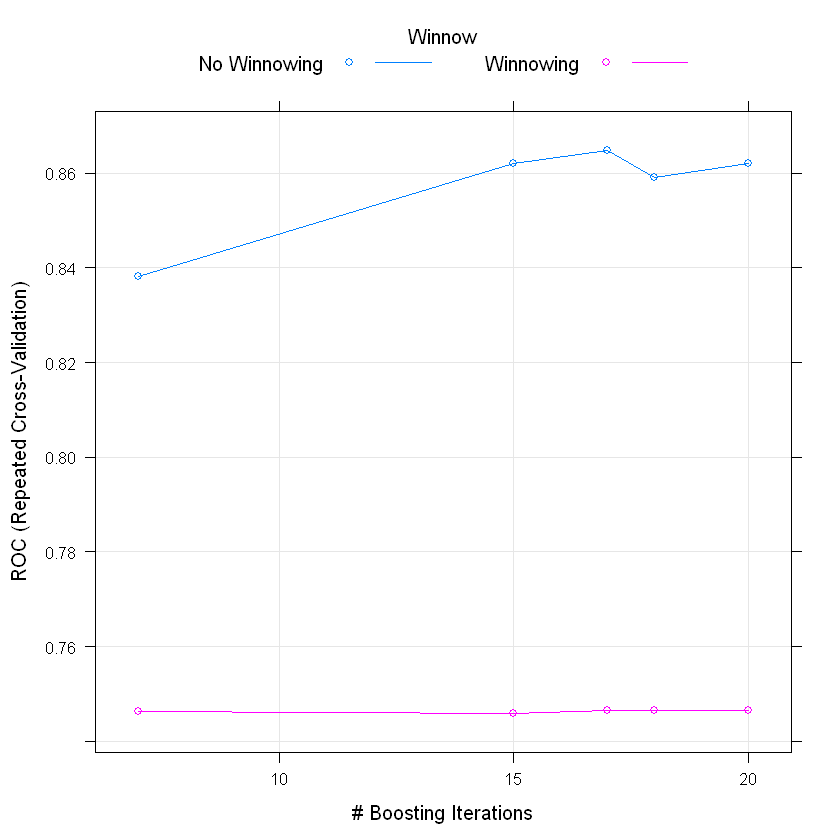

In [158]:
plot(model_DT_2)
print(model_DT_2)
#Aplicar el modelo en la base testing


El método de munualGrid obtiene mejores resultados que el modelo normal, pero requiere de ir probando valores para ir acotando el resultado

In [165]:
print("MODELO ORIGINAL")
print(cmDT)
print("MODELO MANUAL GRID")
DTprediction_MG <-predict(model_DT_2, testing)
cmDT_MG <-confusionMatrix(DTprediction_MG,testing$Class)
print(cmDT_MG)

[1] "MODELO ORIGINAL"
Confusion Matrix and Statistics

          Reference
Prediction  M  R
         M 27  6
         R  6 23
                                          
               Accuracy : 0.8065          
                 95% CI : (0.6863, 0.8958)
    No Information Rate : 0.5323          
    P-Value [Acc > NIR] : 6.468e-06       
                                          
                  Kappa : 0.6113          
                                          
 Mcnemar's Test P-Value : 1               
                                          
            Sensitivity : 0.8182          
            Specificity : 0.7931          
         Pos Pred Value : 0.8182          
         Neg Pred Value : 0.7931          
             Prevalence : 0.5323          
         Detection Rate : 0.4355          
   Detection Prevalence : 0.5323          
      Balanced Accuracy : 0.8056          
                                          
       'Positive' Class : M               
              

### RANDOM FOREST

El siguiente Random Forest tiene 2 hiperparámetros para configurar:
- mtry: Número de variables muestreadas al azar como candidatos en cada división.
- ntree: Número de árboles para crecer que viene definido por default en 500



Cargamos la libreria para el modelo 

In [167]:
#install.packages("randomForest")
library(randomForest)

Random Forest 

146 samples
 60 predictor
  2 classes: 'M', 'R' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 131, 131, 132, 132, 131, 132, ... 
Resampling results across tuning parameters:

  mtry  ROC        Sens       Spec     
   1    0.9303005  0.9065476  0.7174603
   2    0.9355726  0.8982143  0.7603175
   3    0.9332625  0.8815476  0.7555556
   4    0.9266156  0.8773810  0.7404762
   5    0.9290604  0.8732143  0.7452381
   6    0.9267574  0.8726190  0.7555556
   7    0.9214994  0.8732143  0.7555556
   8    0.9287273  0.8684524  0.7603175
   9    0.9147109  0.8690476  0.7507937
  10    0.9226190  0.8773810  0.7547619
  11    0.9071854  0.8553571  0.7595238
  12    0.9120465  0.8553571  0.7460317
  13    0.9195011  0.8607143  0.7603175
  14    0.9090774  0.8684524  0.7603175
  15    0.8998937  0.8690476  0.7595238
  16    0.9031817  0.8559524  0.7500000
  17    0.9062642  0.8684524  0.7404762
  18    0.9036139  0.8553571  0.7

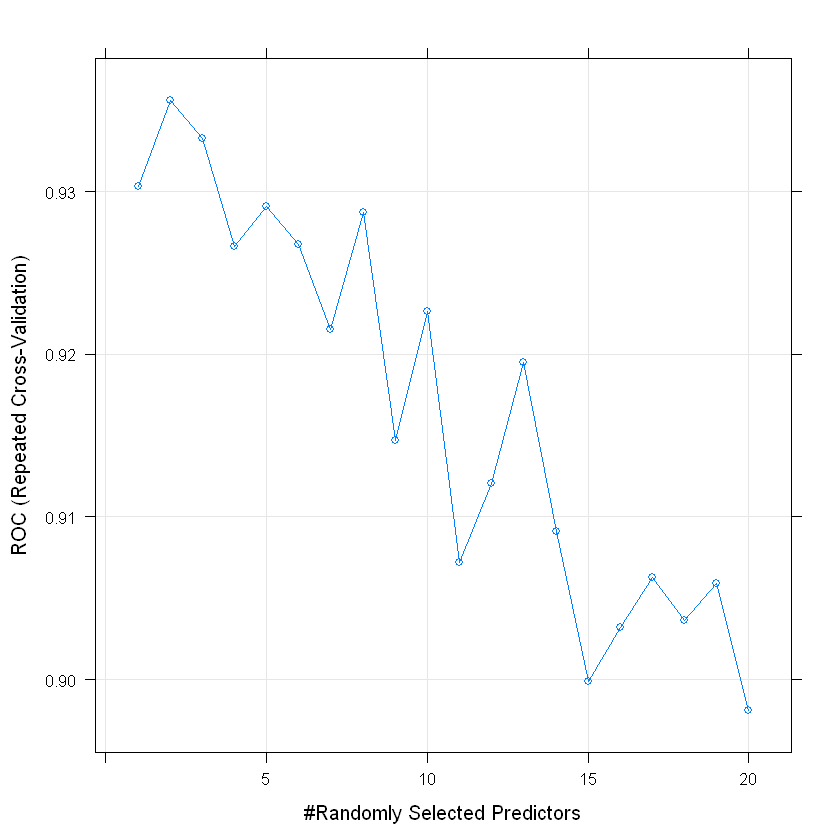

In [174]:
#Definimos la configuración de entrenamiento como un cross validation 10 fold con 3 repeticiones
control_rf <- trainControl(method="repeatedcv", number=10, repeats=3, summaryFunction = twoClassSummary,
                               classProbs = TRUE)
# definimos los valores para mtry seran del 1 al 20 
grid_rf <- expand.grid(.mtry=c(1:20))
rf <- train(Class~., data=training, method="rf", metric="ROC", tuneGrid=grid_rf, trControl=control_rf)
print(rf)
plot(rf)


El numero óptimo para mtry es 2

#### Confuguración del **ntree** 

In [198]:
#Definimos la configuración de entrenamiento como un cross validation 10 fold sin repeticiones
control_rf_2 <- trainControl(method="cv", number=10, summaryFunction = twoClassSummary,
                               classProbs = TRUE)
# definimos los valores para mtry seran del 1 al 20 
rf_grid2 <- expand.grid(.mtry=c(1:20))

#creamos una lista vacia para ir guardando los distintos modelos
rf_list <- list()

# mediante un loop vamos probando los distintos valores de ntree. 
## estos van desde el 100 al 500 cada 50. Es decir 100 - 150 - 200 - 250 .......- 400 - 450 - 500
for (i in seq(200, 600, by = 50)) {
  set.seed(1)
  rf4 <- train(Class ~., 
               data = training, 
               method = "rf", 
               metric = "ROC", 
               tuneGrid = rf_grid2, 
               ntree = i, 
               trControl = control_rf_2)
  key <- toString(i)
  rf_list[[key]] <- rf4
  
}

Comparamos los resultados

In [200]:
bosques <- resamples(rf_list)
summary(bosques)


Call:
summary.resamples(object = bosques)

Models: 200, 250, 300, 350, 400, 450, 500, 550, 600 
Number of resamples: 10 

ROC 
         Min.   1st Qu.    Median      Mean   3rd Qu. Max. NA's
200 0.7500000 0.9183673 0.9375000 0.9289116 0.9813988    1    0
250 0.8214286 0.8973214 0.9136905 0.9250425 0.9794855    1    0
300 0.7678571 0.8921131 0.9336735 0.9249150 0.9741709    1    0
350 0.7500000 0.9129464 0.9808673 0.9339711 0.9955357    1    0
400 0.7500000 0.9129464 0.9808673 0.9339711 0.9955357    1    0
450 0.7500000 0.9151786 0.9808673 0.9366497 0.9955357    1    0
500 0.7500000 0.9167730 0.9808673 0.9346088 0.9821429    1    0
550 0.7500000 0.9167730 0.9808673 0.9355017 0.9821429    1    0
600 0.7500000 0.9084821 0.9795918 0.9301446 0.9821429    1    0

Sens 
     Min.   1st Qu. Median      Mean 3rd Qu. Max. NA's
200 0.500 0.8750000 0.9375 0.8982143   1.000    1    0
250 0.625 0.8616071 0.8750 0.8571429   0.875    1    0
300 0.625 0.7767857 0.8750 0.8446429   0.875    1    0
350 0

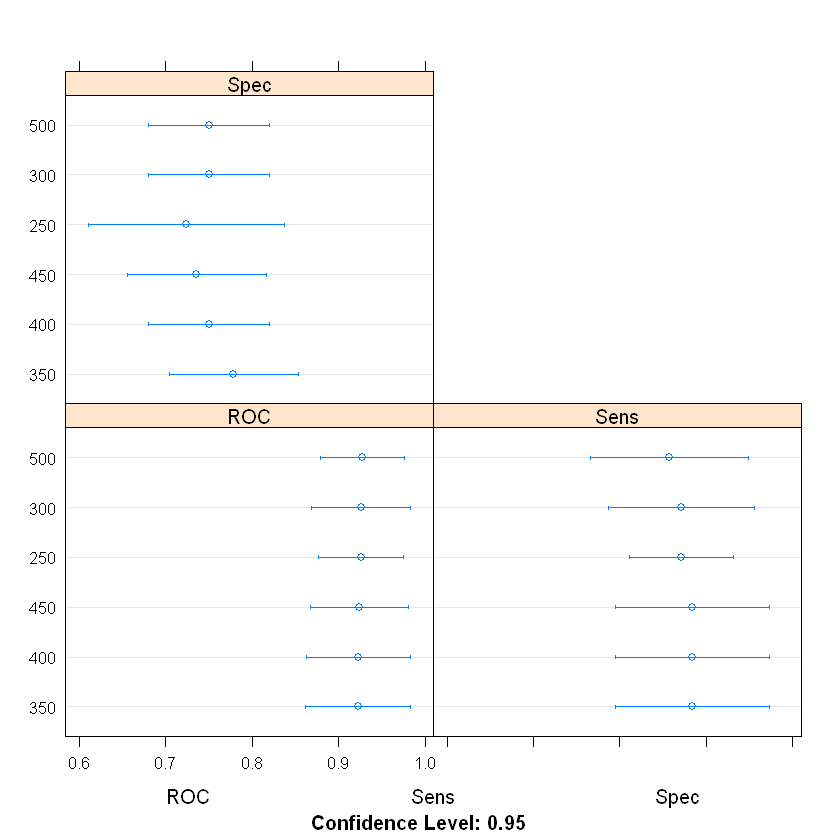

In [201]:
dotplot(results)

Podemos notar que el mejor resultado ROC lo tiene el **ntree = 500**

Ahora a partir de **ntree =500** buscamos el óptimo para **mtry** 

In [202]:
rf_list$`500`$bestTune

mtry
<int>
1


Lista de los resultados para el ntree=500

In [203]:
rf_list$`500`$results

mtry,ROC,Sens,Spec,ROCSD,SensSD,SpecSD
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.9346088,0.9250000,0.7071429,0.09101394,0.10540926,0.14892324
2,0.9149660,0.8982143,0.7523810,0.09055424,0.09926387,0.13801311
3,0.9232143,0.8857143,0.7214286,0.07220362,0.12463097,0.14110477
4,0.9119898,0.8571429,0.7642857,0.07617100,0.12821821,0.10191539
5,0.9244898,0.8714286,0.7523810,0.07212095,0.10233942,0.13801311
6,0.9136905,0.8464286,0.7380952,0.07677823,0.11424851,0.13327663
7,0.9250000,0.8303571,0.7500000,0.06360970,0.14217346,0.09736384
8,0.9214286,0.8571429,0.7357143,0.06751859,0.12821821,0.13110861
9,0.9102041,0.8446429,0.7666667,0.07345805,0.11846584,0.12387056


Grafico de los distintos valores de **mtry** para ntree=500

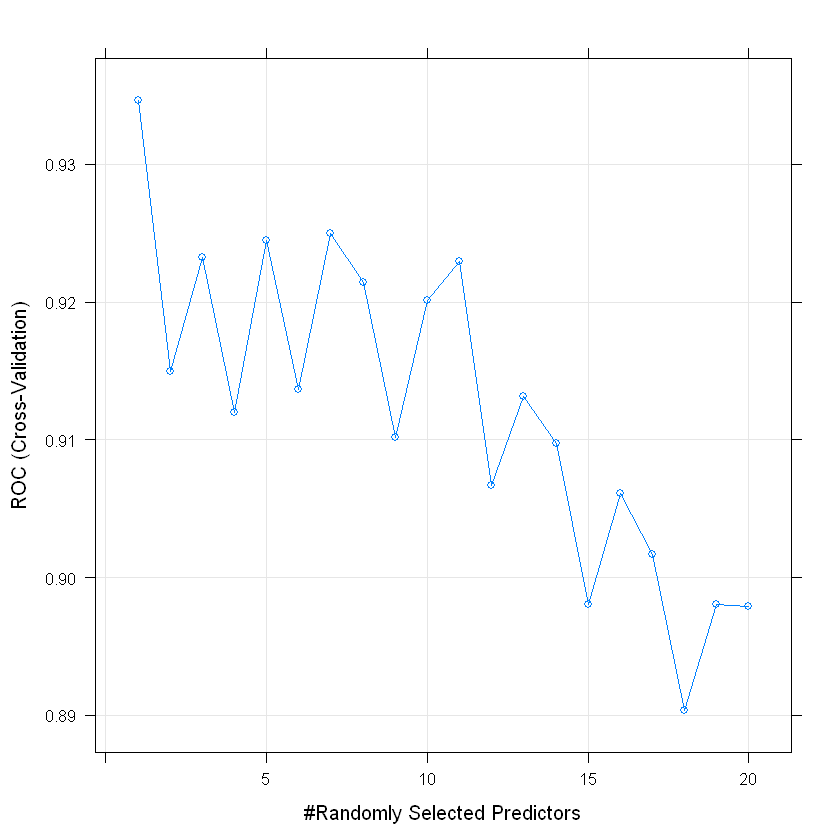

In [204]:
rf_list$`500` %>%
  plot()